# Пронозирование вероятности банкротства

## Введение

**Цель проекта:**

Спрогнозировать вероятность банкроства компании. 


**Задача проекта:**

Построить предиктивную модель, которая на основании открытых данных о судах и бухгалтерской отчетности позволит спрогнозировать вероятность банкротства компании. 


**Целевые метрики:**
* **ROC-AUC** - площадь, ограниченная ROC-кривой и осью доли ложно-положительных классификаций. Чем выше показатель ROC-AUC-score, тем качественнее модель определяет клиентов обоих классов.

* **F1** - гармоническое среднее precision и recall. Мотивация:

    - Precision покажет долю компаний, названных классификатором банкротами и при этом действительно являющимися банкротами. Recall покажет какую долю компаний-банкротов из всех компаний-банкротов нашла модель. 
    
    - У нас нет инфорации о специфике бизнес задачи, поэтому мы не знаем что клиенту важнее - максимально точно определить потенциальных банкротов (тогда фокус на recall) или важнее реже ошибаться в прогнозах (тогда фокус на precision). Поэтому в качестве целевой метрики берем F1, которая будет отвечать за высокие значения обоих метрик.

**Стартовый набор данных:**

* json-файлы судебных дел, поле case_sides.type принимает значения {0:'истец', 1:'ответчик', 2:'свидетель'}.
* Файл df_bankruptcies_sample со списком компаний, претерпевших банкротство. Если компания в списке отсутствует, значит банкротства у нее не было.
* Файл df_accounts с информацией об активах и задолженностях компаний. Поле okei отвечает за единицу измерения {383:'рубль', 384:'тысяча рублей', 385:'миллион рублей'}.


**Целевой признак:**
* Факт банкротства. 1: банкрот, 0: нет

## Формирование датафрейма

Готовим окружение для формирования датафрейма.

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings("ignore")

### Account and Bankrupt data

Для начала считаем два датасета с информацией о клиентах.

In [2]:
df_account = pd.read_csv('df_accounts_sample.csv', index_col=0)

In [3]:
df_bank = pd.read_csv('df_bankruptcies_sample.csv', index_col=0)

#### Активы и задолженности компаний

In [4]:
df_account.sample(10)

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
342,6454050638,2017,125.0,426578,274643,384
1011,7708570018,2019,0.0,28686,148594,384
481,3814022520,2015,0.0,0,0,383
37,2508012923,2012,100257.0,186219,486660,384
0,2465002653,2012,0.0,113756,122240,384
509,5530000076,2015,7098.0,19482,58851,384
891,6105007117,2018,0.0,1511,4873,384
988,6636002484,2020,NaN,6068,7729,384
369,1822000100,2014,0.0,7793,524,384
506,1822000100,2015,0.0,7793,423,384


Имеем следующие данные:
* ИНН комапнии
* Отчетный год
* Долгосрочные финансовые обязательства на момент этого года
* Краткосрочные финансовые обязательства на этот год
* Финансовые активы на этот год
* Код порядка указанных сумм

In [5]:
df_account.groupby('inn')['year'].count().reset_index().sort_values('year', ascending=False)

,inn,year
37,3212001450,10
117,6725005494,10
14,1822000100,10
27,2508012923,10
114,6636002484,9
...,...,...
94,5837068476,2
75,5042125258,2
157,7802646458,1
38,3217002312,1


Итого на вход есть 166 разных компаний с отчетностями за период от 1 до 10 лет. 

In [6]:
df_account.isna().mean()

inn                                   0.000000
year                                  0.000000
long_term_liabilities_fiscal_year     0.072464
short_term_liabilities_fiscal_year    0.000000
balance_assets_fiscal_year            0.000000
okei                                  0.000000
dtype: float64

In [7]:
df_account[df_account.long_term_liabilities_fiscal_year.isna()].groupby('year')['okei'].count()

year
2019    38
2020    37
Name: okei, dtype: int64

In [8]:
df_account = df_account.fillna(0)

Есть пропущенне значения в данных за последние два года о долгосрочных финансовых обязательсвах. Предоложу что тут пропущены нули и эти компании не имеют долгосроных долговых обязательств.

Приведем все финансовые данные к цифрам одного порядка, зафиксировав их в млн. рублей.

In [9]:
df_account.okei.unique()

array([384, 383], dtype=int64)

In [10]:
df_account.okei.replace({383: 1, 384: 1000, 385: 1_000_000}, inplace=True)

In [11]:
df_account[
    ['long_term_liabilities_fiscal_year',
     'short_term_liabilities_fiscal_year',
     'balance_assets_fiscal_year']
] = df_account[
    ['long_term_liabilities_fiscal_year',
     'short_term_liabilities_fiscal_year',
     'balance_assets_fiscal_year']
].mul(df_account.okei, axis=0) / 1_000_000

In [12]:
df_account.drop('okei', axis=1, inplace=True)

Для всех ИНН сгенерируем новые фичи - лаг на один год по трем финансовым показателям:

Годовой Лаг = Показатели В Этом Году - Показатели В Прошлом Году

In [13]:
df_account.drop_duplicates(inplace=True)

In [14]:
df_account.sort_values(['inn', 'year'], inplace=True)
df_account

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year
772,1001003743,2012,0.000,1.080,4.399
187,1001003743,2013,0.000,1.080,4.399
357,1001003743,2014,0.000,0.296,6.295
548,1001003743,2015,0.000,0.260,6.051
623,1001003743,2016,0.000,0.861,4.735
...,...,...,...,...,...
721,9102060446,2016,39.286,58.196,160.340
327,9102060446,2017,33.350,168.422,272.612
833,9102060446,2018,6.000,178.345,257.065
1033,9102060446,2019,6.000,229.769,308.868


In [15]:
list_inn = df_account.inn.drop_duplicates().to_list()
df_acc_lags = df_account.copy().iloc[0:0]

Ход вычислений:
* Итерируемся по всем ИНН
* Для каждого ИНН считаем лаги
* Объединяем в общую таблицу

In [16]:
for inn in tqdm(list_inn):
    inn_df = df_account[df_account.inn == inn].copy().sort_values('year')
    inn_df['lt_liabilities_diff'] = inn_df['long_term_liabilities_fiscal_year'] - inn_df['long_term_liabilities_fiscal_year'].shift()
    inn_df['st_liabilities_diff'] = inn_df['short_term_liabilities_fiscal_year'] - inn_df['short_term_liabilities_fiscal_year'].shift()
    inn_df['balance_diff'] = inn_df['balance_assets_fiscal_year'] - inn_df['balance_assets_fiscal_year'].shift()
    df_acc_lags = pd.concat([df_acc_lags, inn_df])

In [17]:
df_acc_lags.fillna(0, inplace=True)
df_acc_lags.head(15)

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff
772,1001003743,2012,0.000,1.080,4.399,0.000,0.000,0.000
187,1001003743,2013,0.000,1.080,4.399,0.000,0.000,0.000
357,1001003743,2014,0.000,0.296,6.295,0.000,-0.784,1.896
548,1001003743,2015,0.000,0.260,6.051,0.000,-0.036,-0.244
623,1001003743,2016,0.000,0.861,4.735,0.000,0.601,-1.316
300,1001003743,2017,0.000,8.379,9.481,0.000,7.518,4.746
862,1001003743,2018,0.000,3.881,4.003,0.000,-4.498,-5.478
894,1001003743,2019,0.000,4.330,3.930,0.000,0.449,-0.073
588,1020010136,2015,0.000,3.900,3.451,0.000,0.000,0.000
631,1020010136,2016,0.000,16.187,12.526,0.000,12.287,9.075


In [18]:
df_account = df_acc_lags.copy()

Теперь посчитаем current ratio - отношение всех задолженностей к текущим активам.
Сразу же нормализуем параметр для компаний с нулевым балансом.

In [19]:
df_account['current_ratio'] = (
    df_account.long_term_liabilities_fiscal_year + df_account.short_term_liabilities_fiscal_year
) / (df_account.balance_assets_fiscal_year + 0.01) 

df_account['current_ratio'][df_account['current_ratio'] > 20] = 20

Перейдем к данным о банкротах.

#### Данные о компаниях-банкротах

In [20]:
df_bank.sample(10)

,bankrupt_id,bancrupt_year,inn
11,76122,2015,1302000640
9,131574,2016,6454050638
99,432052,2020,1429006530
27,77381,2021,5044075933
62,73325,2014,6453113557
74,289836,2019,5638055144
89,358377,2021,7621009707
16,63390,2014,6443017981
77,262277,2019,5028024427
13,168481,2017,8909000186


In [21]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   bankrupt_id    106 non-null    int64
 1   bancrupt_year  106 non-null    int64
 2   inn            106 non-null    int64
dtypes: int64(3)
memory usage: 3.3 KB


Данные:

* ИНН комапнии. Всего компаний 106 шт.
* Год банкротства
* ID компании-банкрота

Препроцессинг:
- Проверим дубликаты
- Уберем из таблицы id который нам не пригодится. 
- Переименуем фичу год банкротсва для удобного джойна.

In [22]:
df_bank.duplicated().sum()

0

In [23]:
df_bank = df_bank.drop('bankrupt_id', axis=1)

In [24]:
df_bank.rename(columns={'bancrupt_year':'year'}, inplace=True)

#### Объединяем данные.

Итак нужно из двух датасетов получить один.

Он должен включать в себя:
- Уникальный инн компании
- Последний год, за который у нас есть данные в df_account или год банкротсва.
- Финансовые показатели.
- Целевая фича - банкрот или нет.

Для начала выделим банкротов из всех 166 компаний о которых у нас есть данные.

Для этого смерджим два датасета по ИНН комапнии.

Получим датасет с данными финансовой отчетности для комапний банкротов.

In [25]:
bankrupts = pd.merge(df_bank, df_account, on=['inn'])

In [26]:
bankrupts.duplicated().sum()

0

In [27]:
bankrupts.drop_duplicates(inplace=True)

In [28]:
bankrupts.inn.nunique()

106

In [29]:
bankrupts.sort_values('inn').tail(15)

,year_x,inn,year_y,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio
520,2019,8617004112,2015,0.000,0.417,1.145,0.000,-0.249,-0.546,0.361039
521,2019,8617004112,2017,0.000,4.853,6.230,0.000,4.436,5.085,0.777724
374,2011,8908001998,2012,0.000,7.668,17.507,0.000,0.000,0.000,0.437746
376,2011,8908001998,2014,0.000,3.416,80.361,0.000,-29.732,37.237,0.042503
377,2011,8908001998,2015,0.000,2.992,71.756,0.000,-0.424,-8.605,0.041691
378,2011,8908001998,2016,0.000,4.048,74.769,0.000,1.056,3.013,0.054133
379,2011,8908001998,2017,0.000,6.012,97.285,0.000,1.964,22.516,0.061791
380,2011,8908001998,2018,0.000,3.622,109.892,0.000,-2.390,12.607,0.032957
381,2011,8908001998,2019,0.000,8.636,130.731,0.000,5.014,20.839,0.066054
382,2011,8908001998,2020,0.000,14.318,128.891,0.000,5.682,-1.840,0.111077


Всего 106 компаний, о которых известен факт банкротства.

Но мы видим, что например компания с ИНН 8908001998 обанкротилась в 2011 году, а данные по этому ИНН есть и за 2020 год в том числе. 

Либо в данных есть ошибка, либо после банкротсва по этому же ИНН работает компания не банкрот(та же самая или новая, не уверен в юридической стороне этого вопроса).

Посчитаем какой период разделяет год банкротства и последний год наблюдений. 

Полагаю, что если компания обанкротилась в 2021 году то последние данные могут быть только за 2020 год., т.к. в за 2021 данные они просто не успеют подать.

In [30]:
bankrupts = bankrupts.loc[bankrupts.groupby("inn")["year_y"].idxmax()] 
bankrupts['year_diff'] = (bankrupts.year_x - 1) - bankrupts.year_y 
bankrupts[bankrupts.year_diff != 0].sample(10)

,year_x,inn,year_y,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio,year_diff
394,2012,5404263460,2017,0.0,0.000,0.000,0.000,-0.001,-0.010,0.000000,-6
629,2021,2465002653,2019,0.0,34.938,60.193,0.000,-24.775,-23.929,0.580337,1
320,2011,3321004436,2015,0.0,53.937,16.390,0.000,6.268,1.645,3.288841,-5
302,2014,2111000271,2015,0.0,0.000,0.010,0.000,-4.491,-5.526,0.000000,-2
91,2017,8909000186,2015,0.0,18.359,21.788,0.000,-1.663,-9.050,0.842233,1
41,2017,3503004631,2019,0.0,3.820,0.000,0.000,-1.022,-1.022,20.000000,-3
606,2021,7728812071,2018,1198.0,2749.901,3950.874,663.893,2452.153,3117.901,0.999245,2
323,2014,5504002704,2014,0.0,6.121,6.688,0.000,-7.168,-8.233,0.913855,-1
445,2019,7727656060,2015,0.0,649.582,650.867,0.000,187.459,188.446,0.998010,3
107,2014,6443017981,2014,0.0,0.232,0.232,0.000,0.027,-0.010,0.958678,-1


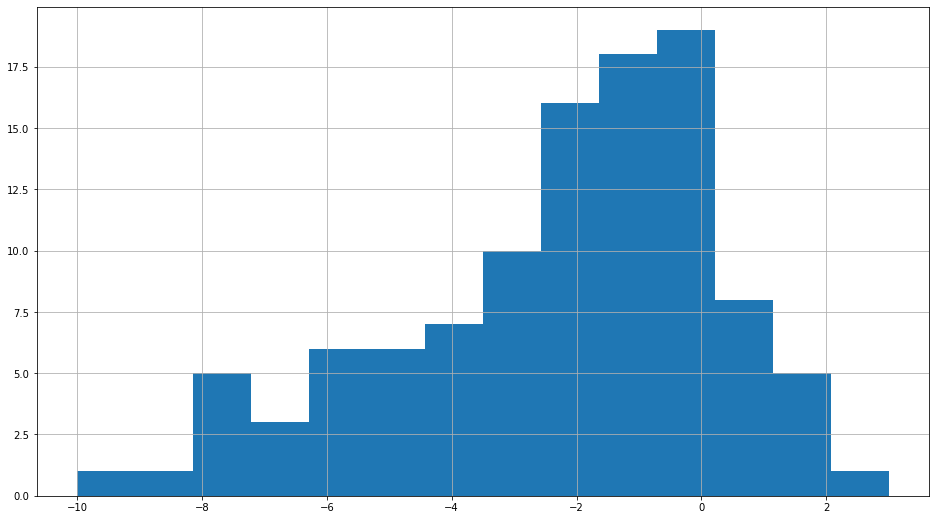

In [31]:
bankrupts.year_diff.hist(figsize=(16,9),bins=14);

Разница между годом банкроства и годом имеющихся данных в большинстве своем меньше 0.

Что это означает:
Допустим известно что компания обанкротилась в 2015 году. Но у нас есть наблюдения до 2017 года. Значит на период 2015-2017 года компания уже не может считать банкротом. 

Что делать:
**Чтобы разметить эту компанию как банкрот нам нужны данные только до момента банкротства.** Конкретно для этого примера мы возьмем только данные на 2014 год (за год до банкротства). По ним и смерджим.

Итак, новый мердж:
- Из года банкроства вычитаем один год. (Если банкрот в 2021 нам нужно джойнить с данными за 2020)
- Мерджим по ИНН и получившемуся году.

In [32]:
df_bank.year -= 1

In [33]:
bankrupts = pd.merge(df_bank, df_account, on=['inn', 'year'])

In [34]:
bankrupts.inn.nunique()

73

In [35]:
bankrupts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   year                                74 non-null     int64  
 1   inn                                 74 non-null     int64  
 2   long_term_liabilities_fiscal_year   74 non-null     float64
 3   short_term_liabilities_fiscal_year  74 non-null     float64
 4   balance_assets_fiscal_year          74 non-null     float64
 5   lt_liabilities_diff                 74 non-null     float64
 6   st_liabilities_diff                 74 non-null     float64
 7   balance_diff                        74 non-null     float64
 8   current_ratio                       74 non-null     float64
dtypes: float64(7), int64(2)
memory usage: 5.8 KB


In [36]:
bankrupts[bankrupts.inn==7703065332] 

,year,inn,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio
68,2020,7703065332,104.013,1.482,112.154,0.0,-0.872,-1.692,0.940542
69,2020,7703065332,104.013,1.481,112.154,0.0,-0.001,0.000,0.940534


Один ИНН попался дважды, данные идентичны. Отбросим одну строку.

In [37]:
bankrupts.drop_duplicates('inn',inplace=True)

In [38]:
bankrupts.sample(10)

,year,inn,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio
11,2015,6900000290,0.000,95.038,176.487,-1.680,-20.690,-68.411,0.538468
19,2015,5501078737,8.000,371.202,518.804,8.000,-28.148,-14.264,0.730902
59,2017,6732030100,0.000,187.370,187.717,0.000,3.198,2.930,0.998098
70,2020,2318010808,38.421,19.128,14.339,2.025,6.767,-0.388,4.010663
9,2014,3525092769,37.451,436.970,602.464,-40.383,-6.947,-103.385,0.787455
67,2020,3436108015,13.705,8.327,10.180,4.368,-7.236,-18.152,2.162120
44,2016,7814290213,0.000,2.152,68.535,0.000,-1.135,34.253,0.031395
21,2013,7714149601,140.863,240.380,265.929,-1.499,120.065,5.183,1.433573
26,2014,5406339932,2.791,256.735,216.402,0.000,-4.820,-26.886,1.199222
39,2014,7326037640,0.000,72.862,83.846,-27.598,20.200,-7.063,0.868894


Итого имеем 73 компании-банкрота, для коотрых представлены данные **на момент банкроства**.

Присвоим им значение целевой фичи = 1.

In [39]:
bankrupts['is_bankrupt'] = 1

Все не-банкроты - те ИНН, которые не представлены в bankrupts.

Для них возьмем максимально свежие данные о состоянии компаний.

In [40]:
solvents = df_account[~df_account.inn.isin(bankrupts.inn)]

In [41]:
solvents = solvents.loc[solvents.groupby("inn")["year"].idxmax()] 
solvents

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio
894,1001003743,2019,0.000,4.330,3.930,0.000,0.449,-0.073,1.098985
868,1435087440,2018,0.831,0.758,5.917,0.500,-0.361,1.117,0.268095
863,1609004518,2018,0.000,0.000,0.048,0.000,-0.312,-1.922,0.000000
870,1645020900,2018,0.000,64.814,61.284,0.000,26.457,22.927,1.057428
867,1656033107,2018,0.000,8.055,6.814,0.000,0.190,-0.062,1.180393
...,...,...,...,...,...,...,...,...,...
1030,7842353970,2020,0.000,2.548,16.411,-0.017,-2.315,-1.538,0.155167
848,8901998318,2018,0.000,0.000,0.020,0.000,-0.259,-0.239,0.000000
1032,8908001998,2020,0.000,14.318,128.891,0.000,5.682,-1.840,0.111077
562,8909000186,2015,0.000,18.359,21.788,0.000,-1.663,-9.050,0.842233


In [42]:
solvents.inn.nunique()

93

Таких компаний соотвественно 166 - 73 = 93. 

Для них - целевая фича = 0.

In [43]:
solvents['is_bankrupt'] = 0

Соеденим два датафрейма вместе и получим размеченные ИНН с данным о каждой компании на указанный год.

In [44]:
new_df = pd.concat([solvents, bankrupts]).reset_index(drop=True)
new_df.rename(columns={'inn':'company_inn'}, inplace=True)

In [45]:
new_df.sample(10)

,company_inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio,is_bankrupt
34,4523004705,2017,0.000,2.181,0.000,0.000,0.610,0.000,20.000000,0
31,4347021100,2018,0.000,1.580,0.117,0.000,1.514,0.000,12.440945,0
13,2814002385,2020,0.000,0.197,0.646,0.000,-0.641,0.035,0.300305,0
47,5530000076,2019,0.000,0.149,12.079,0.000,-0.142,-4.297,0.012325,0
2,1609004518,2018,0.000,0.000,0.048,0.000,-0.312,-1.922,0.000000,0
9,2465002653,2019,0.000,34.938,60.193,0.000,-24.775,-23.929,0.580337,0
137,7814290213,2016,0.000,2.152,68.535,0.000,-1.135,34.253,0.031395,1
63,6662111440,2020,9.502,15.982,25.353,9.502,14.120,23.539,1.004771,0
112,5501078737,2015,8.000,371.202,518.804,8.000,-28.148,-14.264,0.730902,1
133,5504002704,2013,0.000,13.289,14.921,0.000,0.827,-0.056,0.890027,1


#### Вывод


Из сырых данных о клиентах и факте их банкроства собрали размеченный датасет, в котором:
- Компании-небанкроты представлены последними финансовыми данными имеющимися в распоряжении.
- Компании-банкроты представлены последними финансовыми данными на год перед банкроством.

### Court data

#### Извлечение данных

Для начала создадим словарь, где каждому ИНН будет соответствовать тот год, до которого собраны данные.
Это необходимо для того, чтобы избежать попадания в датасет данных из будущего.

In [46]:
final_observation_year = new_df[['company_inn', 'year']].set_index('company_inn').to_dict()['year']

Предварительно посмотрев что за данные содержит каждый файл подготовим процесс преобработки и формирования датафрейма с помощью pandas.

Процесс сбора данных из .pkl файлов:
1. Итерируемся по всем файлам в архиве.
1. Создаем базовые переменные для каждого файла.
1. Читаем файл, переводим данные в формат для работы с помощью pandas.
1. Из первого подзапроса получаем ИНН компании
1. Проверяем есть ли данные о судебных делах. Если нет - добавялеем ИНН без данных о делах и переходим к следющим файлам.
1. Есть дела есть - начинаем обрабатывать.
1. Получаем список датафреймов с судебными делами. Оставляем из них только релевантные сравнивая с годом наблюдений в размеченом датафрейме.
1. Разделяем дела по характеру усчастия в них искомой компании. Отдельно дела в качестве истца, ответчика и свидетеля.
1. Для каждого характера участия считаем:
    * Общее кол-во дел
    * Кол-во незакрытых дел
    * Кол-во и сумма компенсации для выиграных дел (если истец - результат "Выиграно", если ответчик результат "Проиграно")
    * Кол-во и сумма компенсации для проиграных дел (если истец - результат "Проиграно", если ответчик результат "Выиграно")
    * Кол-во дел каждого типа   
1. Фомируем итоговую строку с фичами для конкртеного ИНН, добавялем ее в список.
    * **number_of_cases_TypeName** - общее кол-во дел для  статуса TypeName
    * **prec_number_active_cases_TypeName** - процент незакртых дел для статуса TypeName
    * **perc_win_cases_TypeName** - процент выиграных дел для статуса TypeName
    * **per_lose_cases_TypeName** - процент проиграных дел для статуса TypeName
    * **sum_of_compensation_win_per_case_TypeName** - средняя сумма компенсаций в случае выигрыша дела для статуса TypeName
    * **sum_of_compensation_lose_per_case_TypeName** - средняя сумма компенсаций в случае проигрыша дела для статуса TypeName
    * **perc_case_type_CaseType_on_TypeName** - процент дел типа CaseType для статуса TypeName
1. Формируем датафрейм из этого списка.
    

In [47]:
path = 'court_cases_sample/'
files = os.listdir(path)
all_case_type_names = pd.DataFrame()
all_result_types = pd.Series()
list_of_dfs = []

In [48]:
for n, file in tqdm(enumerate(files)):
    # create dataframe for final data
    final_row = pd.DataFrame()
    
    # basic values
    company_name = 'Неизвестно'
    company_INN  = 0
    
    # read file
    with open(os.path.join(path, file), 'rb') as f:
        d = pickle.load(f) 
    
    # first normalize - basic
    basic_df = json_normalize(d)

    company_INN = basic_df.inn.values[0]
    final_row = final_row.append({'company_inn': company_INN}, ignore_index=True)
    
    # check if no cases
    if len(basic_df.cases_list.values[0]) == 0:
        list_of_dfs.append(final_row)
        continue 

    # second normalize - cases_list
    cases_list = pd.concat([pd.DataFrame(json_normalize(x)) for x in basic_df['cases_list']],ignore_index=True)
    cases_list.instanceDate = pd.to_datetime(cases_list.instanceDate, errors='coerce')
    cases_list.instanceDate = pd.DatetimeIndex(cases_list['instanceDate']).year
    
    # check only relevant data
    if company_INN in final_observation_year:
        cases_list = cases_list[cases_list.instanceDate <= final_observation_year[company_INN]+1]

    # getting case types names
    df_case_type_names = cases_list[['caseType.code', 'caseType.name']].drop_duplicates()
    all_case_type_names = pd.concat([all_case_type_names, df_case_type_names])
       
    # preparing dataframes
    client_cases = pd.DataFrame(columns=cases_list.columns)
    dfndt_cases = pd.DataFrame(columns=cases_list.columns)
    witness_cases = pd.DataFrame(columns=cases_list.columns)

    for i, x in enumerate(cases_list['case_sides']):
        # third normalize for every row - case_sides
        current_case = pd.DataFrame(json_normalize(x))
        if len(current_case) == 0:
            continue

        current_case.INN =  pd.to_numeric(current_case.INN, downcast='integer', errors='coerce')
        
        #get company name
        if i == 0:
            company_name = current_case[current_case.INN == company_INN].name.values[0]
        # check if don't have inn or name    
        if company_INN in current_case.INN.values or company_name in current_case.name.values:

                type_ = current_case[(current_case.INN == company_INN) | (current_case.name == company_name)].type.values[0]

                if type_ == 0:
                    client_cases = pd.concat([client_cases, pd.DataFrame(cases_list.iloc[i]).T])

                elif type_ == 1:
                    dfndt_cases = pd.concat([dfndt_cases, pd.DataFrame(cases_list.iloc[i]).T])

                elif type_ == 2:
                    witness_cases = pd.concat([witness_cases, pd.DataFrame(cases_list.iloc[i]).T])
        else:
            continue
                
    full_cases = [client_cases, dfndt_cases, witness_cases]
    full_cases_names = ['client', 'defendant', 'witness']
    final_row['company_name'] = company_name

    # counting basic data
    for case_type, name in zip(full_cases,full_cases_names):
        number_of_cases = len(case_type)
        number_active_cases = len(case_type[case_type.isActive == True])
        if name == 'client':
            win = case_type[(case_type.resultType == 'Выиграно') | (case_type.resultType == 'Иск полностью удовлетворен')].copy()
            lose = case_type[(case_type.resultType == 'Проиграно') | (case_type.resultType == 'В иске отказано полностью')].copy()
            number_win_cases = len(win)
            number_lose_cases = len(lose)
            sum_of_compensation_win = win['sum'].sum() / 1_000_000
            sum_of_compensation_lose = lose['sum'].sum() / 1_000_00
            
        elif name == 'defendant': 
            lose = case_type[(case_type.resultType == 'Выиграно') | (case_type.resultType == 'Иск полностью удовлетворен')].copy()
            win = case_type[(case_type.resultType == 'Проиграно') | (case_type.resultType == 'В иске отказано полностью')].copy()
            number_win_cases = len(win)
            number_lose_cases = len(lose)
            sum_of_compensation_win = win['sum'].sum() / 1_000_000
            sum_of_compensation_lose = lose['sum'].sum() / 1_000_000
        else:
            number_win_cases = 0
            number_lose_cases = 0
            sum_of_compensation_win = 0
            sum_of_compensation_lose = 0
        
        types = case_type['caseType.code'].unique()
        count_types = {}
        for c in types:
            count_types[c] = len(case_type[case_type['caseType.code'] == c]) 

        final_row['_'.join(['number_of_cases', name])] = number_of_cases
        
        if number_of_cases > 0:
            final_row['_'.join(['prec_number_active_cases', name])] = number_active_cases / number_of_cases
            final_row['_'.join(['perc_win_cases', name])] = number_win_cases / number_of_cases
            final_row['_'.join(['per_lose_cases', name])] = number_lose_cases / number_of_cases
            final_row['_'.join(['sum_of_compensation_win_per_case', name])] = sum_of_compensation_win / number_of_cases
            final_row['_'.join(['sum_of_compensation_lose_per_case', name])] = sum_of_compensation_lose / number_of_cases

            for k in count_types:
                final_row['_'.join(['perc_case_type', k, 'on', name])] = count_types[k] / number_of_cases
                
    list_of_dfs.append(final_row)
    
pkl_df = pd.concat(list_of_dfs, axis=0, ignore_index=True)

In [49]:
pkl_df.company_inn.nunique()

193

In [50]:
pkl_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_inn,193,NaN,NaN,NaN,5.12586e+09,2.18664e+09,1.001e+09,3.40303e+09,5.4141e+09,7.10401e+09,9.10206e+09
company_name,167,160,Неизвестно,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_cases_client,167,NaN,NaN,NaN,16.7485,50.0887,0,0,2,9,476
prec_number_active_cases_client,118,NaN,NaN,NaN,0.0106957,0.0389887,0,0,0,0,0.25
perc_win_cases_client,118,NaN,NaN,NaN,0.250393,0.282821,0,0,0.2,0.366461,1
per_lose_cases_client,118,NaN,NaN,NaN,0.0158566,0.0958794,0,0,0,0,1
sum_of_compensation_win_per_case_client,118,NaN,NaN,NaN,1.6611,7.48512,0,0,0.0005,0.347104,69.5232
sum_of_compensation_lose_per_case_client,118,NaN,NaN,NaN,1.7869,14.3749,0,0,0,0,154.635
perc_case_type_6_on_client,105,NaN,NaN,NaN,0.739966,0.254278,0.155556,0.535714,0.779661,1,1
perc_case_type_5_on_client,67,NaN,NaN,NaN,0.376796,0.30273,0.00925926,0.12782,0.333333,0.5,1


* Обработано 193 файла, получили 193 уникальных ИНН.
* Данные о суднебных делах были только о 167 ИНН (размеченый датафрейм, был из 166 уникальных ИНН)

Разберемся с получившимся пропущенными значениями

#### Постобработка

In [51]:
pkl_df

,company_inn,company_name,number_of_cases_client,prec_number_active_cases_client,perc_win_cases_client,per_lose_cases_client,sum_of_compensation_win_per_case_client,sum_of_compensation_lose_per_case_client,perc_case_type_6_on_client,perc_case_type_5_on_client,...,perc_case_type_73_on_client,perc_case_type_1_on_client,perc_case_type_90_on_defendant,perc_case_type_73_on_defendant,perc_case_type_1_on_witness,perc_case_type_3_on_defendant,perc_case_type_4_on_client,perc_case_type_4_on_defendant,perc_case_type_3_on_client,perc_case_type_90_on_witness
0,1.001004e+09,"ЗАО ""Бытмаш""",3.0,0.000000,0.333333,0.0,0.000000,0.0,0.333333,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.001227e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.020010e+09,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",7.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.203000e+09,"АО ""ССРЗ ИМ. БУТЯКОВА С.Н.""",174.0,0.017241,0.155172,0.0,0.362955,0.0,0.718391,0.132184,...,0.017241,0.034483,0.005076,0.005076,0.25,NaN,NaN,NaN,NaN,NaN
4,1.214003e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,8.617004e+09,"ПОК ""Рябинушка""",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,8.901998e+09,Неизвестно,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,8.908002e+09,"МП ""Аксарковское РПП""",9.0,0.000000,0.000000,0.0,0.000000,0.0,0.333333,0.333333,...,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,8.909000e+09,НПО,1.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,0.058824,NaN,NaN,NaN,NaN


Для начала заполним пропуски:
- В имени компании заполняем значением "Неизвестно"
- Остальные значения заполняем нулями, т.к. данным по ним в файлах не было.

In [52]:
pkl_df.company_name.fillna('Неизвестно', inplace=True)
pkl_df.fillna(0, inplace=True)

In [53]:
pkl_df.company_inn = pkl_df.company_inn.astype('int64')

В процессе итерации собирали все типы дел, которые были обработаны, чтобы воспользоваться при необходимости в процесе EDA.
Сохраним их отдельно.

In [54]:
all_case_type_names.drop_duplicates(inplace=True)
all_case_type_names.reset_index(inplace=True, drop=True)
all_case_type_names.sort_values('caseType.code')

,caseType.code,caseType.name
2,1,о несостоятельности (банкротстве) организаций ...
5,3,об оспаривании решений трет. судов и о выдаче ...
6,4,"об установлении фактов, имеющих юридическое зн..."
1,5,экономические споры по административным правоо...
0,6,экономические споры по гражданским правоотноше...
4,73,об административных правонарушениях
3,90,не определено


Мерджм данные по ИНН комапнии.

In [55]:
df = pd.merge(pkl_df, new_df, on='company_inn')
df.company_inn = df.company_inn.astype('str')
df

,company_inn,company_name,number_of_cases_client,prec_number_active_cases_client,perc_win_cases_client,per_lose_cases_client,sum_of_compensation_win_per_case_client,sum_of_compensation_lose_per_case_client,perc_case_type_6_on_client,perc_case_type_5_on_client,...,perc_case_type_90_on_witness,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio,is_bankrupt
0,1001003743,"ЗАО ""Бытмаш""",3.0,0.000000,0.333333,0.0,0.000000,0.000000,0.333333,0.666667,...,0.0,2019,0.000,4.330,3.930,0.000,0.449,-0.073,1.098985,0
1,1020010136,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",7.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,...,0.0,2017,0.000,36.750,14.769,0.000,20.563,2.243,2.486636,1
2,1203000142,"АО ""ССРЗ ИМ. БУТЯКОВА С.Н.""",174.0,0.017241,0.155172,0.0,0.362955,0.000000,0.718391,0.132184,...,0.0,2019,53.399,395.315,523.849,-159.769,214.115,55.492,0.856555,1
3,1302000640,"СПССК ""ГСМ-Агро""",2.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,...,0.0,2014,3.698,22.189,25.918,0.000,0.000,0.000,0.998419,1
4,1411004211,"СХППК ""Маай""",1.0,0.000000,0.000000,1.0,0.000000,2.375929,1.000000,0.000000,...,0.0,2016,59.514,42.477,146.980,-0.581,-9.761,-17.046,0.693864,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,8617004112,"ПОК ""Рябинушка""",0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,2018,0.000,7.399,8.610,0.000,2.546,2.380,0.858353,1
162,8901998318,Неизвестно,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,2018,0.000,0.000,0.020,0.000,-0.259,-0.239,0.000000,0
163,8908001998,"МП ""Аксарковское РПП""",9.0,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.333333,...,0.0,2020,0.000,14.318,128.891,0.000,5.682,-1.840,0.111077,0
164,8909000186,НПО,1.0,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,...,0.0,2015,0.000,18.359,21.788,0.000,-1.663,-9.050,0.842233,0


In [56]:
df.company_inn.nunique()

166

#### Вывод

После итерирования по файлам получили данные для всех ИНН в файлах.

Итого собрали данные о судебных делах для 166 компаний, которые были даны в изначальном сете. Компании с уникальными ИНН, которых не было в нем в финальный датафрейм не попали, т.к. о них нет никаких финансовых данных.

In [57]:
df.to_csv('bankrupt_final_data.csv', index=False)
all_case_type_names.sort_values('caseType.code').to_csv('case_types_dictionary.csv', index=False)

In [58]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

## Подготовка

Готовим окружение для анализа и посторения моделей.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import optuna
from optuna.samplers import TPESampler

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING


from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set_theme(context = 'paper')

In [60]:
seed = 50
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['figure.figsize'] = 18, 10
pd.set_option('display.float_format', lambda x: '%.4f' % x)

Опишем несколько базовых функций:
* Функция **meet** для знакомства с данными.
* Функция **heatmap_corr** для построения хитмапа по значениям корреляции между фичами.
* Функция **plot_confusionmatrix** для построения матрицы несоответсвия предсказанных и настоящих значений.
* Функция **to_labels** для перевода вероятности класса в бинарную метку.
* Функция **model_result** вывдет данные о реузльтатах предскзания модели.

In [61]:
def meet(df):
    display(df.head(), df.describe(include='all').T)
    df.info()

In [62]:
def heatmap_corr(df, title):
    f, ax = plt.subplots(figsize=(20, 10))
    mat = df.corr()
    mask = np.triu(np.ones_like(mat, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax.tick_params(axis='both', which='major', labelsize=10)
    plt.title(title)
    plt.show()

In [63]:
def plot_confusionmatrix(y, y_pred, title):
    plt.subplots(figsize=(10, 5))
    classes = ['Not Bankrupt', 'Bankrupt']
    print(f'{title} Confusion matrix')
    cf = confusion_matrix(y, y_pred)
    sns.heatmap(cf/np.sum(cf), annot=True, yticklabels=classes,
                xticklabels=classes, cmap='rocket_r', fmt='.2%',annot_kws={"size": 12})
    plt.tight_layout()
    plt.show()

In [64]:
def to_labels(pos_probs, threshold):
        return (pos_probs >= threshold).astype('int')

In [65]:
def model_result():    
    model_result = pd.DataFrame({'MODEL_NAME': MODEL_NAME,                             
                                 'ROCAUC': ROCAUC,
                                 'F1': F1,})
    model_result.sort_values(by=['ROCAUC', 'F1'], inplace=True, ascending=False)
    return model_result

## EDA

Считаем подготовленный ранее датасет, еще раз посмотрим на данные.

In [66]:
case_types = pd.read_csv('case_types_dictionary.csv')

In [67]:
df = pd.read_csv('bankrupt_final_data.csv')
df.company_inn = df.company_inn.astype('str')

In [68]:
meet(df)

,company_inn,company_name,number_of_cases_client,prec_number_active_cases_client,perc_win_cases_client,per_lose_cases_client,sum_of_compensation_win_per_case_client,sum_of_compensation_lose_per_case_client,perc_case_type_6_on_client,perc_case_type_5_on_client,...,perc_case_type_90_on_witness,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio,is_bankrupt
0,1001003743,"ЗАО ""Бытмаш""",3.0000,0.0000,0.3333,0.0000,0.0000,0.0000,0.3333,0.6667,...,0.0000,2019,0.0000,4.3300,3.9300,0.0000,0.4490,-0.0730,1.0990,0
1,1020010136,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",7.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,2017,0.0000,36.7500,14.7690,0.0000,20.5630,2.2430,2.4866,1
2,1203000142,"АО ""ССРЗ ИМ. БУТЯКОВА С.Н.""",174.0000,0.0172,0.1552,0.0000,0.3630,0.0000,0.7184,0.1322,...,0.0000,2019,53.3990,395.3150,523.8490,-159.7690,214.1150,55.4920,0.8566,1
3,1302000640,"СПССК ""ГСМ-Агро""",2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,2014,3.6980,22.1890,25.9180,0.0000,0.0000,0.0000,0.9984,1
4,1411004211,"СХППК ""Маай""",1.0000,0.0000,0.0000,1.0000,0.0000,2.3759,1.0000,0.0000,...,0.0000,2016,59.5140,42.4770,146.9800,-0.5810,-9.7610,-17.0460,0.6939,1


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
company_inn,166,166,7713345804,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_name,166,159,Неизвестно,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_cases_client,166.0000,NaN,NaN,NaN,16.8434,50.2252,0.0000,0.0000,2.0000,9.0000,476.0000
prec_number_active_cases_client,166.0000,NaN,NaN,NaN,0.0076,0.0332,0.0000,0.0000,0.0000,0.0000,0.2500
perc_win_cases_client,166.0000,NaN,NaN,NaN,0.1720,0.2564,0.0000,0.0000,0.0000,0.2932,1.0000
per_lose_cases_client,166.0000,NaN,NaN,NaN,0.0113,0.0811,0.0000,0.0000,0.0000,0.0000,1.0000
sum_of_compensation_win_per_case_client,166.0000,NaN,NaN,NaN,1.1803,6.3482,0.0000,0.0000,0.0000,0.0907,69.5232
sum_of_compensation_lose_per_case_client,166.0000,NaN,NaN,NaN,1.2702,12.1320,0.0000,0.0000,0.0000,0.0000,154.6349
perc_case_type_6_on_client,166.0000,NaN,NaN,NaN,0.4620,0.4103,0.0000,0.0000,0.5000,0.9010,1.0000
perc_case_type_5_on_client,166.0000,NaN,NaN,NaN,0.1521,0.2665,0.0000,0.0000,0.0000,0.2000,1.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 47 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   company_inn                                  166 non-null    object 
 1   company_name                                 166 non-null    object 
 2   number_of_cases_client                       166 non-null    float64
 3   prec_number_active_cases_client              166 non-null    float64
 4   perc_win_cases_client                        166 non-null    float64
 5   per_lose_cases_client                        166 non-null    float64
 6   sum_of_compensation_win_per_case_client      166 non-null    float64
 7   sum_of_compensation_lose_per_case_client     166 non-null    float64
 8   perc_case_type_6_on_client                   166 non-null    float64
 9   perc_case_type_5_on_client                   166 non-null    float64
 10  nu

Итак на вход для построения модели у нас есть:
* 166 уникальных ИНН компаний
* 44 фичи, из которых нужно отобрать только релевантные.


Оценим распредление целевого признака.

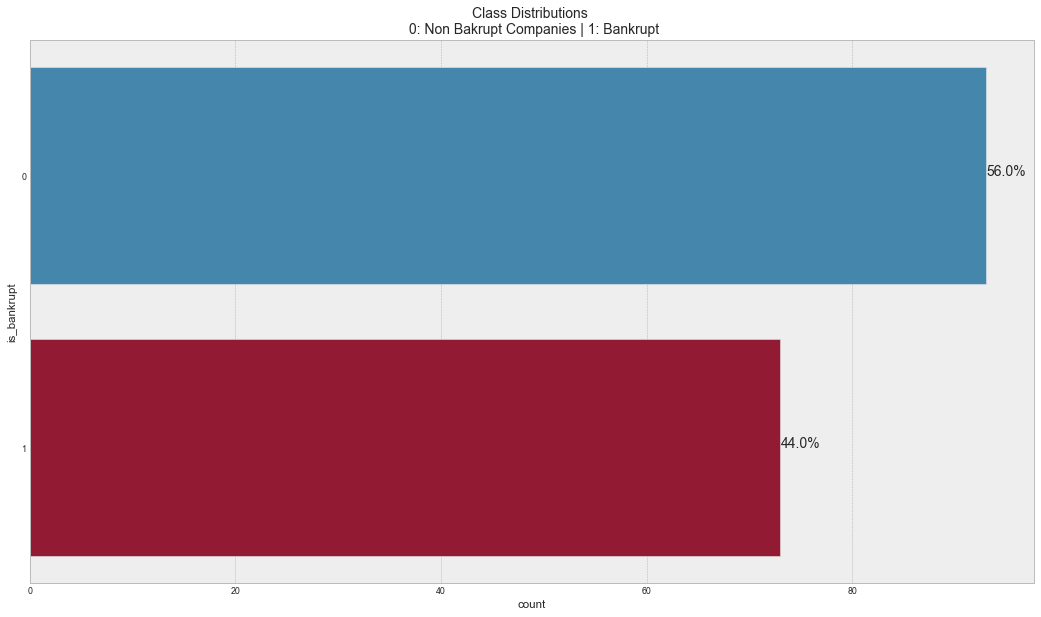

In [69]:
ax = sns.countplot(y="is_bankrupt", data=df)
plt.title('Class Distributions \n 0: Non Bakrupt Companies | 1: Bankrupt', fontsize=14)

total = len(df['is_bankrupt'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=14)

plt.show()

Целевая переменная условно сбалансированная, разница всего 12%. Это хорошо.

Оценим кол-во нулевых значений в каждой из фичей.

In [70]:
zero_percentage = (df[df == 0].count(axis=0)/len(df.index)).sort_values(ascending=False)
zero_percentage.reset_index()

,index,0
0,sum_of_compensation_win_per_case_witness,1.0000
1,perc_win_cases_witness,1.0000
2,per_lose_cases_witness,1.0000
3,sum_of_compensation_lose_per_case_witness,1.0000
4,perc_case_type_3_on_client,0.9940
5,perc_case_type_90_on_witness,0.9880
6,perc_case_type_73_on_client,0.9880
7,perc_case_type_73_on_defendant,0.9880
8,perc_case_type_4_on_defendant,0.9759
9,perc_case_type_4_on_client,0.9699


Очевидно что все фичи с процентом нулевых значений близким к 90% не могут быть релевантны при таком распредлениий классов.

Интуитивно кажется что процент нулей для фичей не должен превышать процент мажорного класс, т.е 56%. Т.к. в противном случае нули будут в значении фичи будут точно представлены для обоих классов. Но при такой границе туда попадут например данные о долгосрочных задолженностях, которые терять не хотелось бы.

Остановлюсь на пороге в 70% пропущенных значений. 

In [71]:
df.drop(zero_percentage[zero_percentage>0.70].index, axis=1, inplace=True)

In [72]:
df.head()

,company_inn,company_name,number_of_cases_client,perc_win_cases_client,sum_of_compensation_win_per_case_client,perc_case_type_6_on_client,perc_case_type_5_on_client,number_of_cases_defendant,number_of_cases_witness,perc_win_cases_defendant,...,perc_case_type_6_on_witness,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,lt_liabilities_diff,st_liabilities_diff,balance_diff,current_ratio,is_bankrupt
0,1001003743,"ЗАО ""Бытмаш""",3.0000,0.3333,0.0000,0.3333,0.6667,0.0000,0.0000,0.0000,...,0.0000,2019,0.0000,4.3300,3.9300,0.0000,0.4490,-0.0730,1.0990,0
1,1020010136,"МУП ""ПРИОНЕЖСКИЙ ВОДОКАНАЛ""",7.0000,0.0000,0.0000,1.0000,0.0000,55.0000,2.0000,0.3636,...,0.5000,2017,0.0000,36.7500,14.7690,0.0000,20.5630,2.2430,2.4866,1
2,1203000142,"АО ""ССРЗ ИМ. БУТЯКОВА С.Н.""",174.0000,0.1552,0.3630,0.7184,0.1322,197.0000,16.0000,0.2386,...,0.5625,2019,53.3990,395.3150,523.8490,-159.7690,214.1150,55.4920,0.8566,1
3,1302000640,"СПССК ""ГСМ-Агро""",2.0000,0.0000,0.0000,1.0000,0.0000,3.0000,0.0000,0.6667,...,0.0000,2014,3.6980,22.1890,25.9180,0.0000,0.0000,0.0000,0.9984,1
4,1411004211,"СХППК ""Маай""",1.0000,0.0000,0.0000,1.0000,0.0000,12.0000,1.0000,0.5000,...,1.0000,2016,59.5140,42.4770,146.9800,-0.5810,-9.7610,-17.0460,0.6939,1


Осталась 21 фича.

Посмотрим на средние значения по каждой пременной для групировки по целевой перменной.

Начнем с финансовых показтелей.

In [73]:
compare_df = df.groupby("is_bankrupt").agg(['median', 'mean'])

In [74]:
financial_cols = ['long_term_liabilities_fiscal_year',
                  'short_term_liabilities_fiscal_year',
                  'balance_assets_fiscal_year', 'lt_liabilities_diff',
                  'st_liabilities_diff', 'balance_diff',
                  'current_ratio']

compare_df[financial_cols].T

is_bankrupt                                      0        1
long_term_liabilities_fiscal_year  median   0.0000   0.0000
                                   mean    26.4499 155.1161
short_term_liabilities_fiscal_year median   4.4770  19.1280
                                   mean   131.2875  94.6254
balance_assets_fiscal_year         median   5.4490  26.9700
                                   mean   199.8176 256.0436
lt_liabilities_diff                median   0.0000   0.0000
                                   mean     1.5115 -29.2435
st_liabilities_diff                median   0.0000   0.7700
                                   mean    37.3173  23.8989
balance_diff                       median  -0.0230  -1.3430
                                   mean    47.1584 -23.8421
current_ratio                      median   0.7841   0.9924
                                   mean     2.7041   1.6569

**Что можно отметить:**

Финансовые показатели

* Средние долгосрочные долговые обязательства сильно выше у банкротов. Но, т.к медианные значения равны нулю - скорее всего это преимущество достигнуто засчет нескольких сильно закредитованых компаний.
* При этом в среднем компании банкроты понизили долгросрочные долговые обязательства на 30 млн. за последний год.

* Средние краткосрочные задолженности выше у не-банкротов. На медианных значениях картина будет прямо противоположной. Предпологаю, что такая разница достигнута засчет крупных компаний не-банкротов, которые могут себе позволить более высокие краткосрочные долговые обязательства. 
* Средний прирост по к/с задолженностям распредлен так же - средние значения показывают примущества банкротов, медианные - не-банкротов. Посмотрим боксплот.

* Баланс активов пожалуй наиболее ярко харрактеризует разницу. Велечина разницы активов распределена в окрестности нуля для не-банкротов, тогда как у компаний банкротов распредление уходит в сторону отрицательных значений. Попросту говоря банкроты потеряли на порядок больше потеряли за полседний год. Посмотрим боксплот.
    
* Рассчитаный на основе баланс и долгов рейтинг тоже не позволяет как-то выделить банкротов из общего числа компаний.

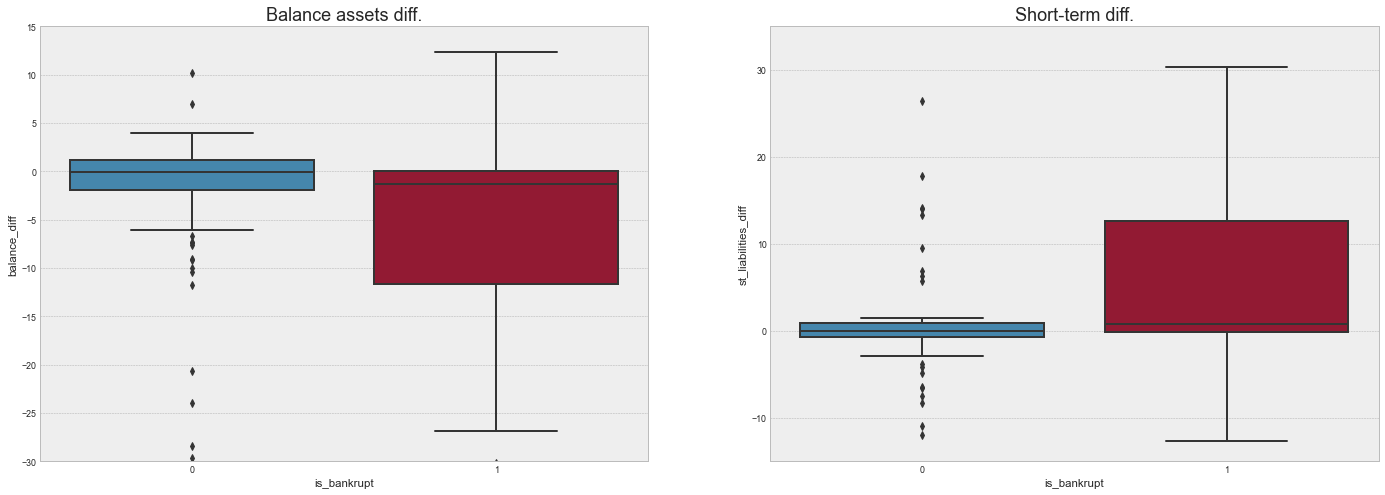

In [75]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="is_bankrupt", y='balance_diff', data=df,ax=ax1) 
ax1.set_title("Balance assets diff.", fontsize=18)
ax1.set_ylim(-30,15)

sns.boxplot(x="is_bankrupt", y='st_liabilities_diff', data=df,ax=ax2) 
ax2.set_title("Short-term diff.", fontsize=18)
ax2.set_ylim(-15,35)
                 
plt.show()

Графики весьма неутешительные для компаний-банкротов.

Таким образом маркеры банкротов:
* Активы с последнего года сильно просели
* Краткосрочный долг сильно вырос.

Перейдем к анализу судебных дел.

In [76]:
compare_df.drop(financial_cols, axis=1).T

is_bankrupt                                               0         1
number_of_cases_client                     median    2.0000    4.0000
                                           mean     13.0538   21.6712
perc_win_cases_client                      median    0.0000    0.0000
                                           mean      0.1687    0.1761
sum_of_compensation_win_per_case_client    median    0.0000    0.0000
                                           mean      0.6781    1.8200
perc_case_type_6_on_client                 median    0.3333    0.6000
                                           mean      0.4277    0.5058
perc_case_type_5_on_client                 median    0.0000    0.0000
                                           mean      0.1720    0.1267
number_of_cases_defendant                  median    3.0000   13.0000
                                           mean     13.8065   29.5479
number_of_cases_witness                    median    0.0000    1.0000
                                           mean      1.9032    2.6438
perc_win_cases_defendant                   median    0.1111    0.3636
                                           mean      0.2496    0.3684
sum_of_compensation_win_per_case_defendant median    0.0000    0.1758
                                           mean      1.0654    0.6846
perc_case_type_6_on_defendant              median    0.7500    0.8571
                                           mean      0.5673    0.7845
perc_case_type_5_on_defendant              median    0.0000    0.0141
                                           mean      0.1680    0.1078
perc_case_type_1_on_defendant              median    0.0000    0.0000
                                           mean      0.0346    0.0619
perc_case_type_6_on_witness                median    0.0000    0.0000
                                           mean      0.2290    0.3073
year                                       median 2018.0000 2016.0000
                                           mean   2018.0323 2015.8767

* Банкроты имеют в среднем в два раза больше судебных дел. И в качестве истцов и в качестве ответчиков. Интуитивно понятно, проблемы в бизнесе приводят к проблем в суде и наоборот.

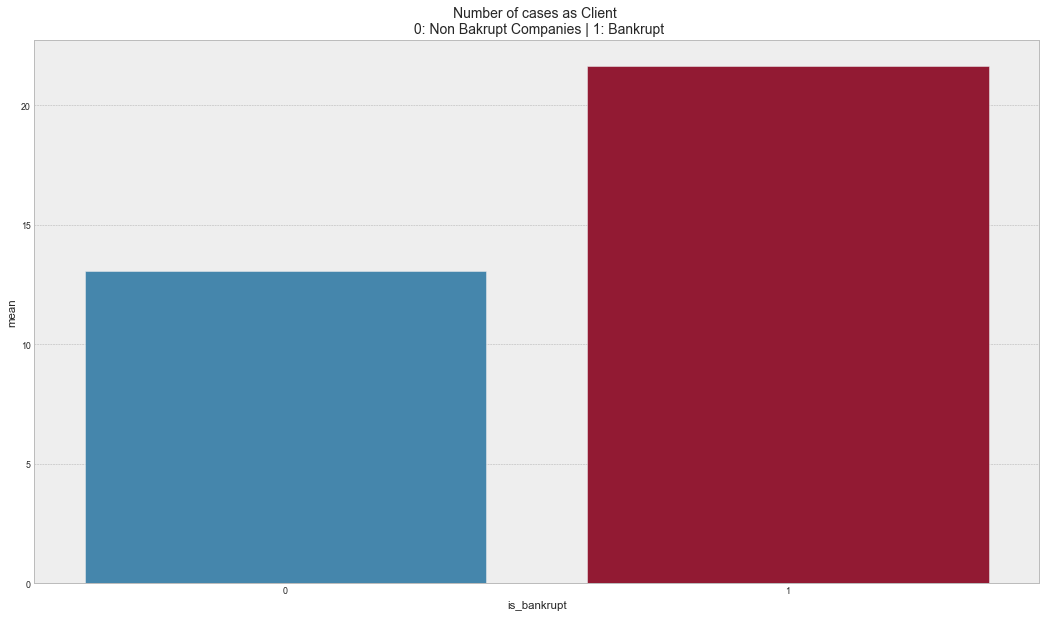

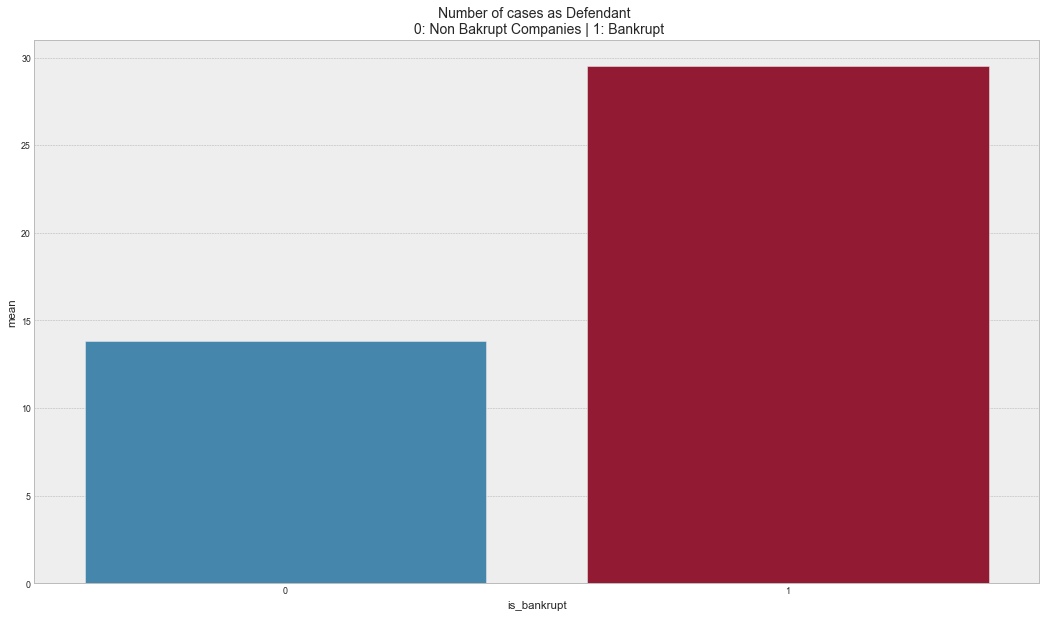

In [77]:
sns.barplot(x='is_bankrupt', y= 'mean',data=compare_df.number_of_cases_client.reset_index())
plt.title('Number of cases as Client \n 0: Non Bakrupt Companies | 1: Bankrupt', fontsize=14)
plt.show()
sns.barplot(x='is_bankrupt', y= 'mean',data=compare_df.number_of_cases_defendant.reset_index())
plt.title('Number of cases as Defendant \n 0: Non Bakrupt Companies | 1: Bankrupt', fontsize=14)
plt.show()

* Но и суммы компенсаций в среднем выше у компаний-банкротов.

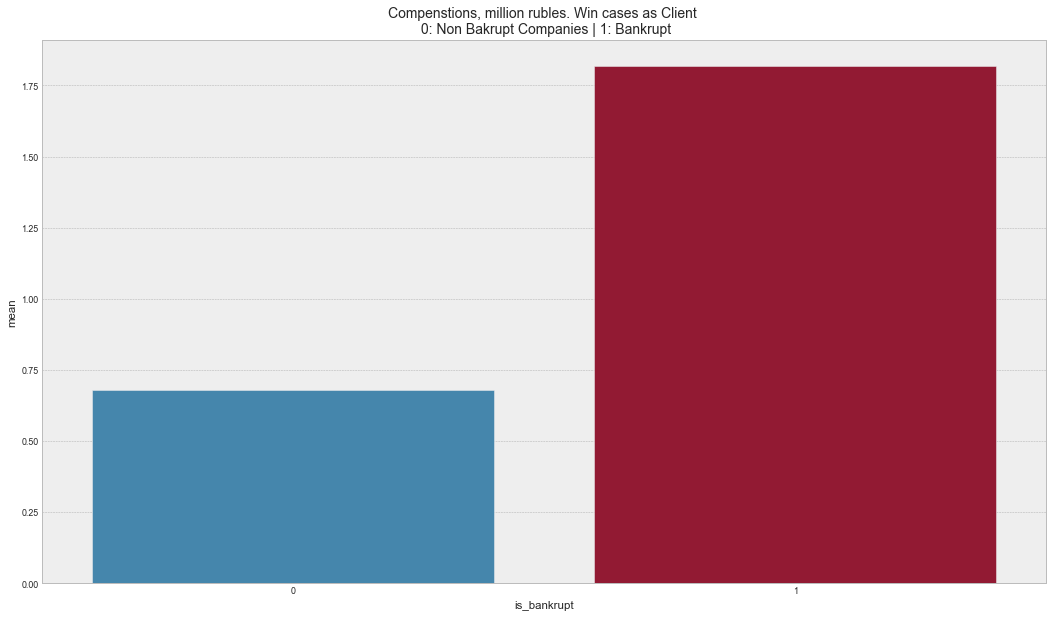

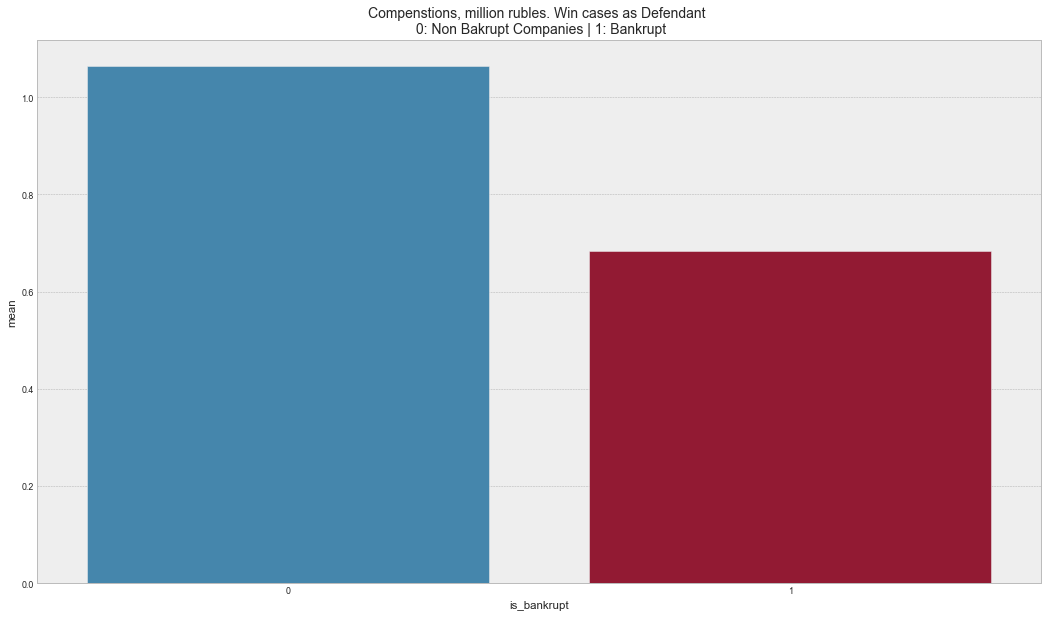

In [78]:
sns.barplot(x='is_bankrupt', y= 'mean',data=compare_df.sum_of_compensation_win_per_case_client.reset_index())
plt.title('Compenstions, million rubles. Win cases as Client \n 0: Non Bakrupt Companies | 1: Bankrupt', fontsize=14)
plt.show()
sns.barplot(x='is_bankrupt', y= 'mean',data=compare_df.sum_of_compensation_win_per_case_defendant.reset_index())
plt.title('Compenstions, million rubles. Win cases as Defendant \n 0: Non Bakrupt Companies | 1: Bankrupt', fontsize=14)
plt.show()

Построим матрицу корреляции между фичами.

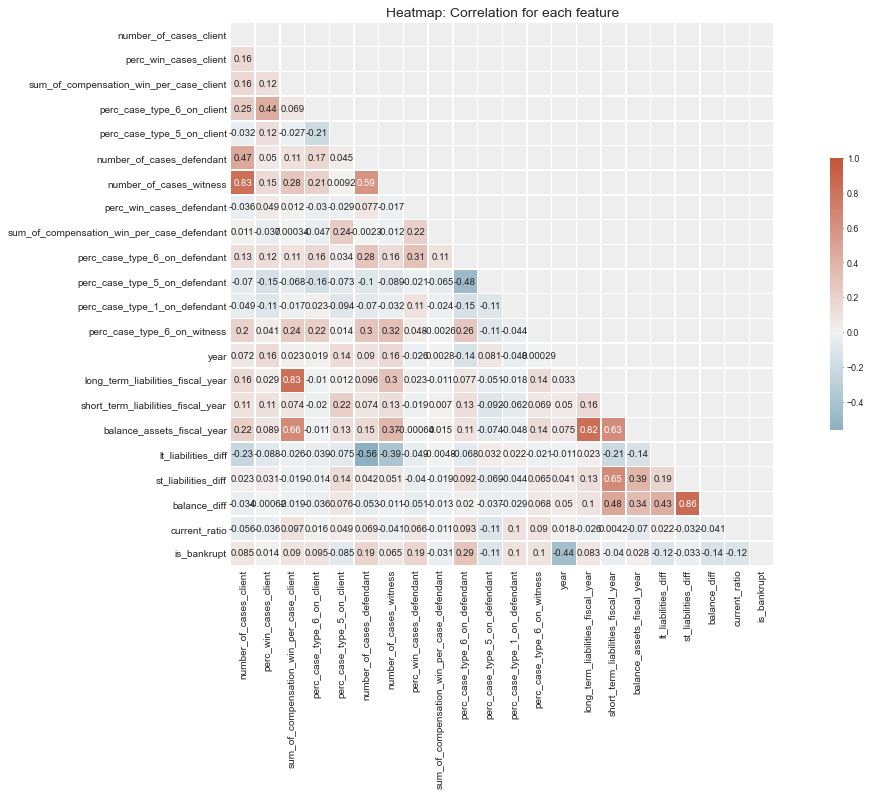

In [79]:
heatmap_corr(df,'Heatmap: Correlation for each feature');

Есть некоторые значимые корреляции между фичами которые были извлечены из данных о судебных делах.

Какие-то из них даже коррелируют с финансовыми показателями, но четкой связи между ними не наблюдается.

Например коэффициент корреляции между приростом долгосрочного долга и числом дел в качестве ответчика составляет -0,56. Т.е. с ростом долга снижается число дел, и наоборот. Что не очень логично выглядит.

С целевой фичей сильно коррелирует только год. Сравним распредленеи в зависимости от года.

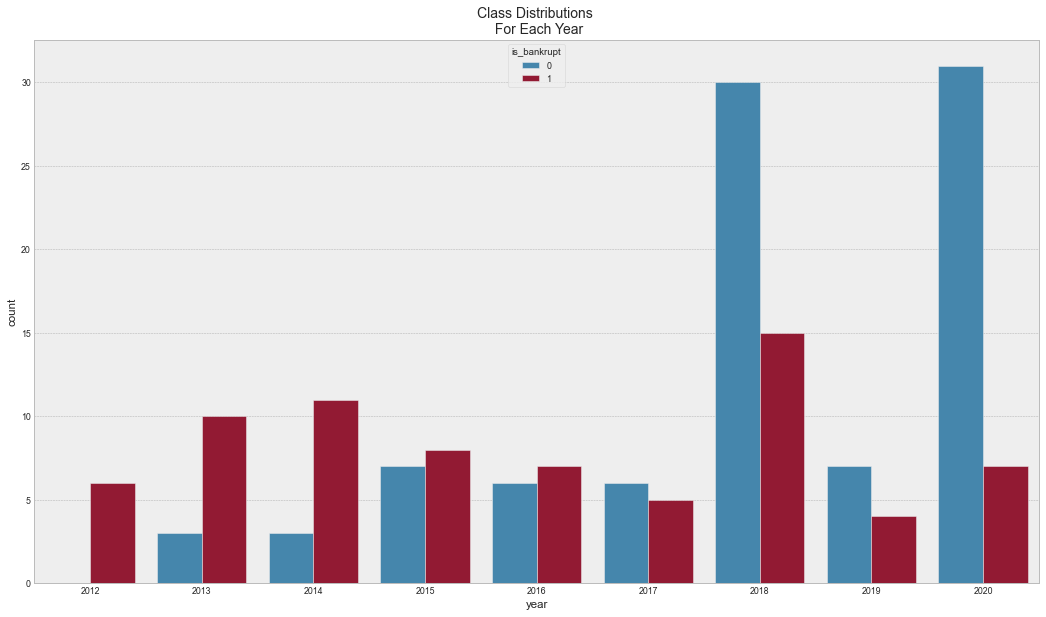

In [80]:
year_df = df.groupby(['year','is_bankrupt'])['company_inn'].count().reset_index()
year_df = year_df.rename({'company_inn': 'count'}, axis=1)
sns.barplot(x='year',y ='count', hue="is_bankrupt", data=year_df)
plt.title('Class Distributions \n For Each Year', fontsize=14)
plt.show()

Компании-банкроты банкротились в течение рассматриваемых 9 лет, тогда как успешные компании продолжали работать. Поэтому к моменту старта исследования для успешных компаний почти все данные актуальные (2018-2020 год) а для компаний-банкротов распредлены в течении всего периода. 

Соответсвенно год нельзя будет использовать как фичу.

In [81]:
numeric_cols = ['balance_assets_fiscal_year', 'short_term_liabilities_fiscal_year',
                'long_term_liabilities_fiscal_year', 'lt_liabilities_diff', 'st_liabilities_diff',
                'balance_diff', 'current_ratio']

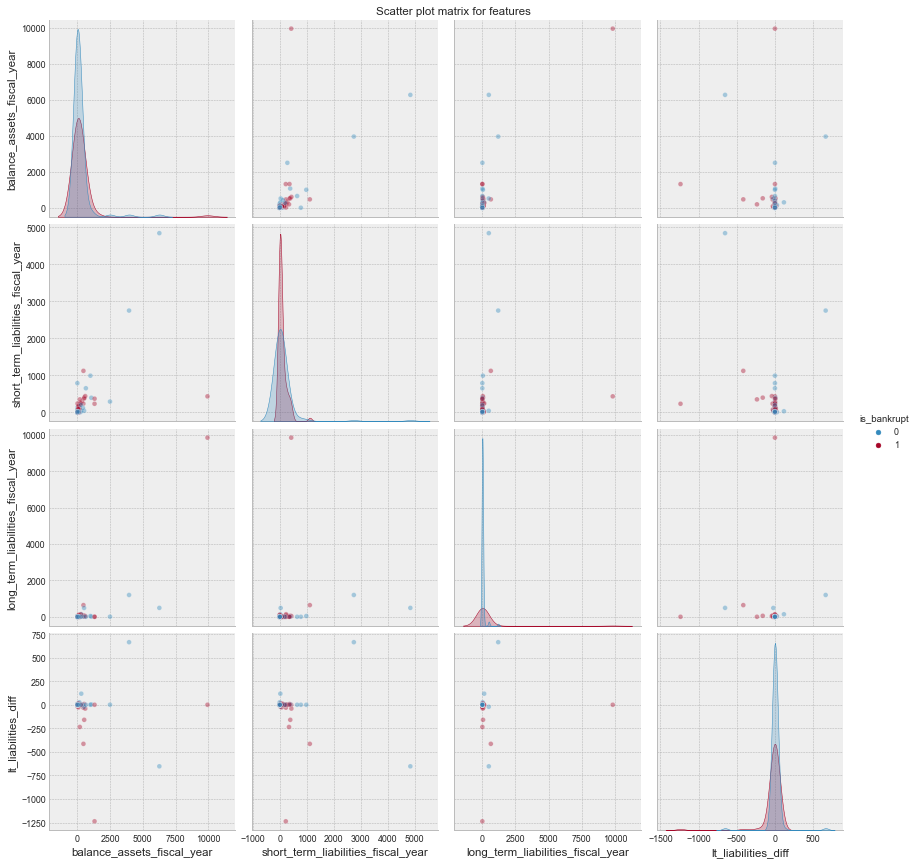

In [82]:
g = sns.pairplot(df, hue="is_bankrupt",
                 x_vars=numeric_cols[:4],
                 y_vars=numeric_cols[:4],
                 kind='scatter', plot_kws={'alpha': 0.4}, size=3)
g.fig.suptitle("Scatter plot matrix for features", y=1);

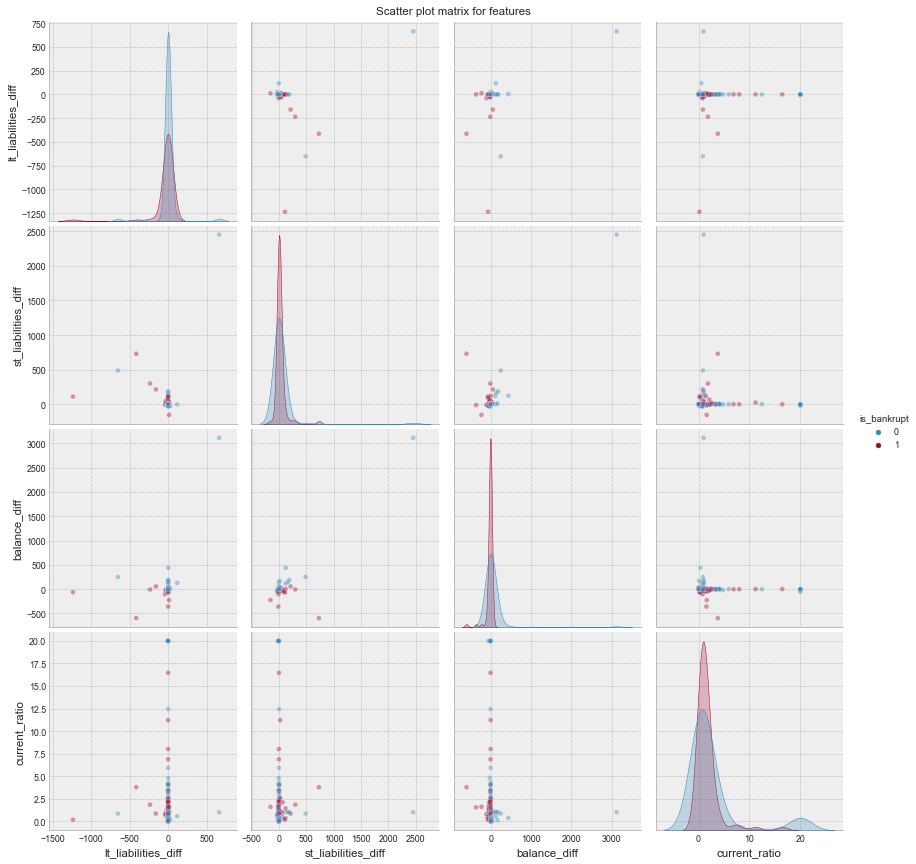

In [83]:
g = sns.pairplot(df, hue="is_bankrupt",
                 x_vars=numeric_cols[3:],
                 y_vars=numeric_cols[3:],
                 kind='scatter', plot_kws={'alpha': 0.4}, size=3)
g.fig.suptitle("Scatter plot matrix for features", y=1);

На диаграммах рассеяния для финансовых фичей банкроты не выделяются, кроме пары ярких красны точек, больше похожих на выбросы.

**Вывод:**

* Ярких откртиый в ходе EDA сделать не удалось. Данные скудные, сильных паттернов почти не наблюдается.
* Из того что действительно хорошо характеризует разницу это данные по приросту краткосрочного долга и изменению баланса активов, еще раз покажу боксплоты ниже.
* Из 44 фичей придуманых в процессе извелечения оставили только 21, все что отбросили преимущественно содержало нули. 

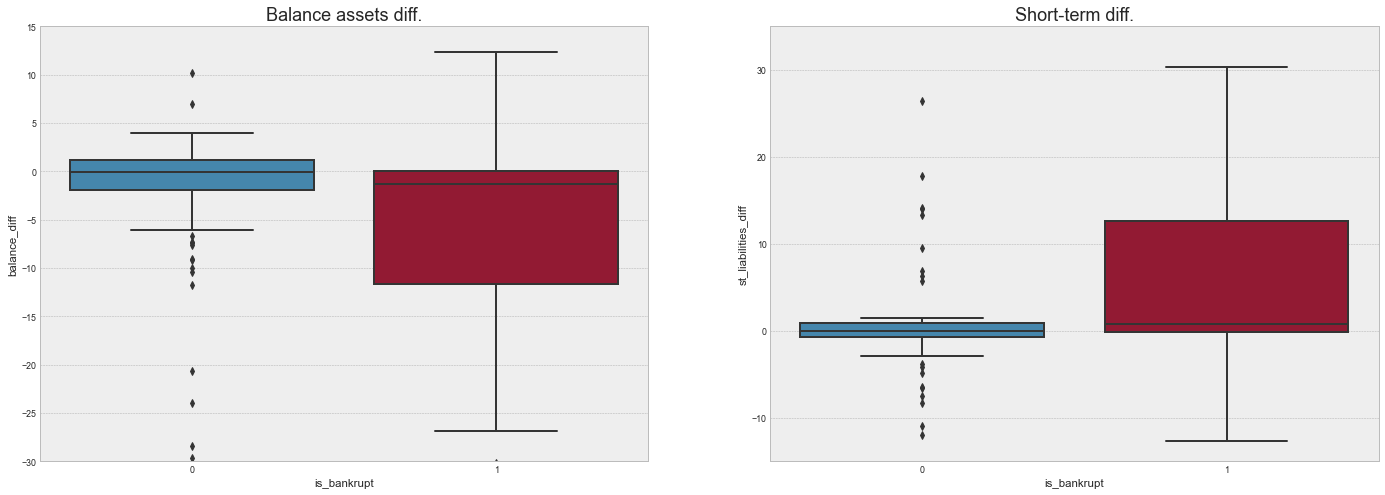

In [84]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="is_bankrupt", y='balance_diff', data=df,ax=ax1) 
ax1.set_title("Balance assets diff.", fontsize=18)
ax1.set_ylim(-30,15)

sns.boxplot(x="is_bankrupt", y='st_liabilities_diff', data=df,ax=ax2) 
ax2.set_title("Short-term diff.", fontsize=18)
ax2.set_ylim(-15,35)
                 
plt.show()

## Baselline модель

Прежде чем приступать к построению модели, необходимо принять решение как мы эту модель будем проверять.

Датасет всего из 166 наблюдений. Велика вероястность того, что полученые реузльтаты метрик будут сильно зависеть от того какие именно наблюдения попадут в холдаут. 

Для бэйзлайна проведем предсказания при 30 параметрах случайного состояния. 

Будем предсказывать:
* F1 для baseline модели. В ходе EDA было видно что можем отсечь банкротов сравнив значение фичи st_liabilities_diff с нулем.
* F1 и ROC-AUC для ванильного CatBoostClassifier c кросс-валидацией по трейну, и указанием веса классов.

Холдаут возьмем 25% от всех данных.

Предварительно убираем из датафрейма лишние данные.

In [85]:
df = df.drop(['company_inn', 'company_name',  'year'], axis=1)

In [86]:
def check_seed(df=df, test_size_=0.25, range_=30, name_='basic', cv_=True, iterations_=90):
    
    seed_NAME = []
    seed_SEED = []
    seed_F1_baseline = []
    seed_ROCAUC_catboost = []
    seed_F1_catboost = []
    seed_THRSH_catboost = []
    thresholds = np.arange(0, 1, 0.001)
    
    for seed_ in tqdm(range(range_)):

        x = df.drop(['is_bankrupt'], axis=1)
        y = df.is_bankrupt

        x_train, x_test, y_train, y_test = train_test_split(x,
                                                            y,
                                                            test_size=test_size_,
                                                            stratify=y,
                                                            random_state=seed_)

        dummy_prediction_test = [0 if x < 0 else 1 for x in x_test.st_liabilities_diff]

        cw = [1, (y_train == 0).sum() / (y_train == 1).sum()]

        if cv_:

            cv_dataset = Pool(data=x_train,
                              label=y_train)

            params = {'loss_function': 'Logloss',
                      'iterations': 300,
                      'verbose': False,
                      'random_seed': seed_}
            scores = cv(cv_dataset,
                        params,
                        fold_count=5
                       )

            iterations = scores.iterations[scores['test-Logloss-mean'] == scores['test-Logloss-mean'].min()].values[0]
        else:
            iterations = iterations_

        model = CatBoostClassifier(iterations = iterations, verbose=False, eval_metric='AUC', class_weights=cw, random_state=seed_)
        model.fit(x_train, y_train)

        cb_pred_proba = model.predict_proba(x_test)[:,1]
        scores = [f1_score(y_test, to_labels(cb_pred_proba, t)) for t in thresholds]
        ix = np.argmax(scores)

        thrsh = thresholds[ix]
        f1_cb_test = scores[ix]
        roc_auc_cb_test = roc_auc_score(y_test, cb_pred_proba)
        f1_baseline_test = f1_score(y_test, dummy_prediction_test)

        seed_NAME.append(name_) 
        seed_SEED.append(seed_) 
        seed_F1_baseline.append(f1_baseline_test)
        seed_ROCAUC_catboost.append(roc_auc_cb_test)
        seed_F1_catboost.append(f1_cb_test)
        seed_THRSH_catboost.append(thrsh)
        
    results = pd.DataFrame({'NAME': seed_NAME,
                            'SEED': seed_SEED,    
                            'F1_baseline': seed_F1_baseline,
                            'F1_catboost': seed_F1_catboost,
                            'THRSH_catboost': seed_THRSH_catboost,
                            'ROCAUC_catboost': seed_ROCAUC_catboost})
    
    results['diff'] = results.F1_catboost - results.F1_baseline
    results.loc['mean'] = results.mean()
    results.sort_values('diff', ascending=False, inplace=True)
    
    return results

In [87]:
check_seed()

,NAME,SEED,F1_baseline,F1_catboost,THRSH_catboost,ROCAUC_catboost,diff
10,basic,10.0000,0.5909,0.8500,0.3590,0.8981,0.2591
14,basic,14.0000,0.4762,0.7222,0.4490,0.7824,0.2460
28,basic,28.0000,0.6000,0.8421,0.4510,0.8727,0.2421
13,basic,13.0000,0.5128,0.7391,0.3540,0.8148,0.2263
20,basic,20.0000,0.5000,0.7234,0.2470,0.7523,0.2234
26,basic,26.0000,0.4762,0.6939,0.1700,0.6921,0.2177
7,basic,7.0000,0.5641,0.7805,0.3650,0.7986,0.2164
15,basic,15.0000,0.6087,0.8182,0.4050,0.8380,0.2095
12,basic,12.0000,0.5532,0.7556,0.3140,0.7569,0.2024
2,basic,2.0000,0.5217,0.7222,0.6160,0.7986,0.2005


Повторим экспеименет предварительно убрав данные о проценте успешности дел. В них много пропусков и в ходе EDA эти фичи себя никак не показали.

In [88]:
df_new = df.drop([col for col in df.columns if col.startswith('perc')],axis=1)

In [89]:
seed_baseline = check_seed(df=df_new, name_='non_percantage_features')

In [90]:
seed_baseline

,NAME,SEED,F1_baseline,F1_catboost,THRSH_catboost,ROCAUC_catboost,diff
14,non_percantage_features,14.0000,0.4762,0.7778,0.5120,0.8287,0.3016
1,non_percantage_features,1.0000,0.6047,0.8649,0.5390,0.9329,0.2602
26,non_percantage_features,26.0000,0.4762,0.7234,0.2860,0.7269,0.2472
20,non_percantage_features,20.0000,0.5000,0.7442,0.4580,0.7801,0.2442
13,non_percantage_features,13.0000,0.5128,0.7556,0.4320,0.8032,0.2427
5,non_percantage_features,5.0000,0.5909,0.8293,0.4800,0.8634,0.2384
10,non_percantage_features,10.0000,0.5909,0.8293,0.4160,0.9005,0.2384
2,non_percantage_features,2.0000,0.5217,0.7500,0.6230,0.8194,0.2283
7,non_percantage_features,7.0000,0.5641,0.7556,0.3580,0.8171,0.1915
12,non_percantage_features,12.0000,0.5532,0.7429,0.5350,0.7986,0.1897


Остановимся на поседней таблице.

Разница метрики F1 между предсказаниями одними и теми же моделями составяет от 0 до 0,30, в зависимости от удачности разбиения на холдаут и трейн.

Такой разброс говорит о том, что принимать решение о качестве модели основываясь только на качестве холдаут выборки будет неправильно.

Но мы уже можем заключить что ванильный CatBoost в среднем превосходит бэйзлайн моедль на 0,15 по метрике F1.

В таком случае работу построим следующим образом:

1. Отделим холдаут выборку равную 25% от всех наблюдений.
1. Проведем препроцессинг: стандартизацию, апсэмплинг.
1. С помощью cv выберем модель из пака CatBoostClassifier, LGBMClassifier, XGBClassifier.
1. Посчитаем целевые метрики на холдауте без тюнинга гиперпараетров
1. Затюним гиперпараетры, сравним метрики на холдауте.
1. Еще раз кросс-валидируемся, но уже на затюнингованых моделях.
1. Полученную моедль проверим для для разных значений seed и сравним с данными полученными на этом этапе.

От фичей с прооцентажем избавимся. Без них средний скор ROC-AUC повыше.

In [91]:
df.drop([col for col in df.columns if col.startswith('perc')],axis=1,inplace=True)

## Выбор классификатора

Выделяем холдаут в 25% от всех данных.

In [92]:
x = df.drop(['is_bankrupt'], axis=1)
y = df.is_bankrupt
feature_columns = x.columns

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=seed)

### Upsampling 

Для борьбы с дисбалансом классов будем использовать методы SMOTE и ADASYN, которые не просто ресемплируют наблюдения, а генерируют новые на основе имеющихся.

Для применения метода нужно передать ему кол-во соседов, по которым будет проводиться генерация. Переберем несколько вариантов для каждого метода и посчитаем метрики на кросс-валидации. Используем модель LGBMClassifier, она побыстрее.

In [94]:
for k in range(1,10):
    model_smote = LGBMClassifier(metric='auc', random_state=seed)
    smote = SMOTE(sampling_strategy=1, k_neighbors=k, random_state=seed)
    steps_smote = [('smote', smote), ('model', model_smote)]
    pipeline_smote = Pipeline(steps=steps_smote)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    model_scores = cross_val_score(pipeline_smote, x_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
    model_score = np.mean(model_scores)

    print('> k=%d, Mean f1: %.3f' % (k, model_score))

> k=1, Mean f1: 0.685
> k=2, Mean f1: 0.661
> k=3, Mean f1: 0.668
> k=4, Mean f1: 0.666
> k=5, Mean f1: 0.691
> k=6, Mean f1: 0.661
> k=7, Mean f1: 0.667
> k=8, Mean f1: 0.668
> k=9, Mean f1: 0.658


In [95]:
for k in range(1,10):
    model_adasyn = LGBMClassifier(metric='auc', random_state=seed)
    adasyn = ADASYN(sampling_strategy=1, n_neighbors=k, random_state=seed)
    steps_adasyn = [('adasyn', adasyn), ('model', model_adasyn)]
    pipeline_adasyn = Pipeline(steps=steps_adasyn)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    model_scores = cross_val_score(pipeline_adasyn, x_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
    model_score = np.mean(model_scores)

    print('> k=%d, Mean f1: %.3f' % (k, model_score))


> k=1, Mean f1: 0.646
> k=2, Mean f1: 0.670
> k=3, Mean f1: 0.667
> k=4, Mean f1: 0.661
> k=5, Mean f1: 0.656
> k=6, Mean f1: 0.663
> k=7, Mean f1: 0.664
> k=8, Mean f1: 0.666
> k=9, Mean f1: 0.668


Лучший вариант:

* SMOTE, при к = 5.

Создаем пустые списки для хранения результатов моделей.

In [96]:
MODEL_NAME = []
ROCAUC = []
F1 = []

Функция для подсчета метрик на кросс-валидации. Важные моменты:
* Препроцессинг:
    * Стандартизация StandardScaler
    * Апсэмплинг
* Кросс валидируемся по 4 фолдам, чтобы размер валидационной выборки был схож с холдаутом. 
* Повторяем разбиения 10 раз. 
* Фолды стратифицирвоаны. 

In [97]:
def model_cv(name, model):
    scalar = StandardScaler()
    smote = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=seed)
    pipeline = Pipeline([('smote', smote), ('transformer', scalar), ('model', model)])
    
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10,  random_state=seed)

    scores_rocauc = cross_val_score(pipeline, x_train, y_train,
                             cv=cv, scoring='roc_auc')
    scores_f1 = cross_val_score(pipeline, x_train, y_train,
                             cv=cv, scoring='f1')
    
    MODEL_NAME.append(name)
    ROCAUC.append(scores_rocauc.mean())
    F1.append(scores_f1.mean())

Формируем список моделей.
* CatBoostClassifier
* LGBMClassifier
* XGBClassifier

Запускаем кросс-валидацию.

In [98]:
ml_models = [
    CatBoostClassifier(iterations=300, early_stopping_rounds=25,
                       verbose=False, eval_metric='AUC',
                       random_state=seed),
    LGBMClassifier(metric='auc', 
                   random_state=seed),
    XGBClassifier(eval_metric='auc',
                  random_state=seed)
]
ml_model_names = ['CatBoost CV', 'LGBM CV', 'XGBoost CV']

In [99]:
for name, model in tqdm(zip(ml_model_names, ml_models)):
    model_cv(name, model)

In [100]:
model_result()

,MODEL_NAME,ROCAUC,F1
1,LGBM CV,0.8023,0.6827
0,CatBoost CV,0.7882,0.6758
2,XGBoost CV,0.7840,0.6570


По итогам кросс валдиации лучше всего себя покзал LGBMClassifier, но и CatBoostClassifier не сильо отстал по F1 скору. Будем тюнинговать обе модели, по итогам выберем одну.

Реализуем препроцессинг, который был на кросс-валидации.

In [101]:
smote = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=seed)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train) 

In [102]:
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train_smote)
x_test = scalar.transform(x_test)
y_train = y_train_smote

x_train = pd.DataFrame(x_train,columns=feature_columns)
x_test = pd.DataFrame(x_test,columns=feature_columns)

In [103]:
model_result()

,MODEL_NAME,ROCAUC,F1
1,LGBM CV,0.8023,0.6827
0,CatBoost CV,0.7882,0.6758
2,XGBoost CV,0.7840,0.6570


**Вывод:**

* Из трех моделей оставили две, которые лучше всего попказали себя на кросс-валидации.
* Провели стандартизацию и апсэмплинг.

Переходим к тюнингу гиперпараметров

## Тюнинг гиперпараметров

Получившиеся моедли нужно как то оценивать.

Функция **model_test:**
* Принимет на вход список гиперпараетров
* ей нужно подсказать для какой модели эти гиперпараетры
* Обучается на тестовых данных
* Делает предикт для холдаута, считает и сохраняет метрики на нем.
* Может вывести матрицу нессотвесвий
* Может вывести важность фичей для этой модели.

In [104]:
def model_test(params, name, cb=False, cm=False, fi=False):
    thresholds = np.arange(0, 1, 0.001)
    if cb:
        model = CatBoostClassifier(**params)
    
    else:
        model = LGBMClassifier(**params)
    
    model.fit(x_train,
              y_train,
              verbose=False)
    preds = model.predict_proba(x_test)[:,1]
    
    scores = [f1_score(y_test, to_labels(preds, t)) for t in thresholds]
    ix = np.argmax(scores)   
    roc_auc = roc_auc_score(y_test, preds)
    f1 = scores[ix]
    

    MODEL_NAME.append(name)
    ROCAUC.append(roc_auc)
    F1.append(f1)
    
    if cm:
        print('Threshold=%.3f, F1-Score=%.5f, ROC-AUC score=%.5f,'  % (thresholds[ix], scores[ix], roc_auc))
        print()
        display(plot_confusionmatrix(y_test, to_labels(preds, thresholds[ix]), f'{name}'))
        
    if fi:
        if cb:
            display(pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': feature_columns}).sort_values(by=['feature_importance'], 
                                                             ascending=False))
        else:    
            lgbm.plot_importance(model);

Перед тюнингом гиперпараметров посчитаем скор на базовых настройках каждой из моделей.

Threshold=0.390, F1-Score=0.78049, ROC-AUC score=0.80787,

Test LGBM Raw Confusion matrix


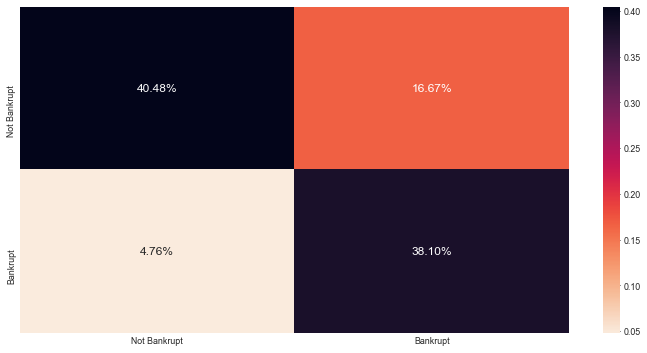

None

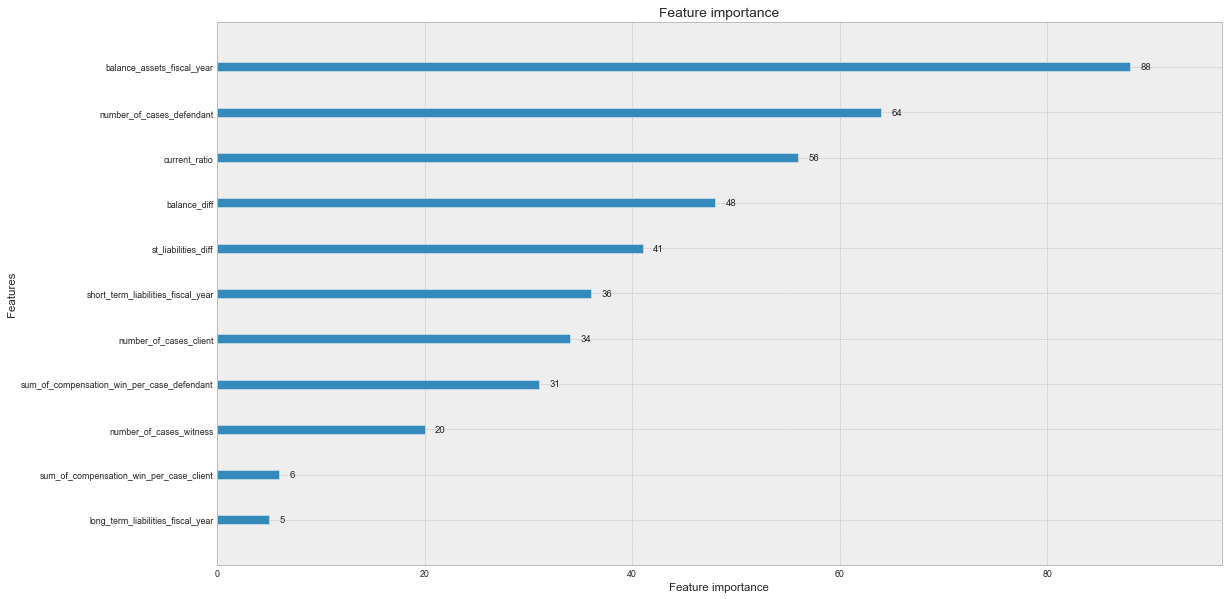

In [105]:
model_test({}, 'Test LGBM Raw', cm=True, fi=True)

Для LGBMClassifier:        

* 16.6% процентов наблюдений были размечены как банкроты, хотя ими не являются.
* 4,7% - наоборот банкроты, которых мы пропустили 

Наиболее важные фичи
* Баланс активов
* Кол-во судебных дел в качестве ответчика
* Рассчитаный на основе баланса и задолженностей current ratio


Threshold=0.415, F1-Score=0.80000, ROC-AUC score=0.86111,

Test CB Raw Confusion matrix


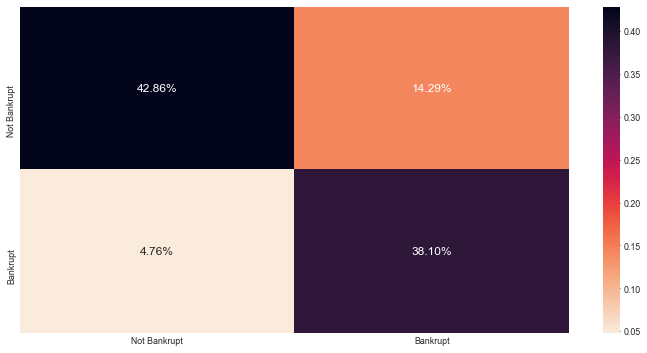

None

,feature_importance,feature_names
2,20.8066,number_of_cases_defendant
7,13.0667,balance_assets_fiscal_year
11,12.3099,current_ratio
10,9.2780,balance_diff
6,8.8896,short_term_liabilities_fiscal_year
9,8.7430,st_liabilities_diff
4,7.5793,sum_of_compensation_win_per_case_defendant
0,5.5597,number_of_cases_client
5,5.1202,long_term_liabilities_fiscal_year
3,3.7267,number_of_cases_witness


In [106]:
model_test({}, 'Test CB Raw', cb=True, cm=True, fi=True)

Для CatBoostClassifier:        

* 14.2% процентов наблюдений были размечены как банкроты, хотя ими не являются.
* 4,7% - банкроты, которых мы пропустили 

CatBoostClassifier справился с классификацией на холдауте немного лучше, о чем говорят значения обеих метрик.

Наиболее важные фичи те же самые, но немного изменил приоритет.
* Кол-во судебных дел в качестве ответчика
* Баланс активов
* Сurrent ratio


In [107]:
model_result()

,MODEL_NAME,ROCAUC,F1
4,Test CB Raw,0.8611,0.8000
3,Test LGBM Raw,0.8079,0.7805
1,LGBM CV,0.8023,0.6827
0,CatBoost CV,0.7882,0.6758
2,XGBoost CV,0.7840,0.6570


### LGBM Optuna

Переходим к тюнингу гиперпарметров.

Будет использовать библиотеку Optuna. 

Опишем функцию, в ней укажем пространства поиска гиперпараметров.

In [108]:
def objective(trial,data=x_train,target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=seed, stratify=target)
    
    param = {
        'random_state': seed,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
    }
    model = LGBMClassifier(**param)  
    
    model.fit(train_x,
              train_y,
              eval_metric='auc',
              eval_set=(test_x,test_y),
              early_stopping_rounds=100,
              verbose=False)
    
    preds = model.predict_proba(test_x)[:,1]
    
    auc_score = roc_auc_score(test_y, preds)
    
    return auc_score

In [109]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))

[I 2021-08-15 23:40:50,424] A new study created in memory with name: no-name-576a2ea7-e73e-418a-a211-b29e128333a8
[I 2021-08-15 23:40:50,451] Trial 0 finished with value: 0.8188775510204082 and parameters: {'n_estimators': 174, 'reg_alpha': 0.008172076393193761, 'reg_lambda': 0.01051709253349873, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 328, 'min_child_samples': 17, 'cat_smooth': 18}. Best is trial 0 with value: 0.8188775510204082.
[I 2021-08-15 23:40:50,465] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 282, 'reg_alpha': 5.650161893204852, 'reg_lambda': 0.718407453888403, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 179, 'min_child_samples': 69, 'cat_smooth': 66}. Best is trial 0 with value: 0.8188775510204082.
[I 2021-08-15 23:40:50,479] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 170, 'reg_alpha': 0.0019669321061154808, 'reg_lambda': 

[I 2021-08-15 23:40:51,057] Trial 22 finished with value: 0.826530612244898 and parameters: {'n_estimators': 148, 'reg_alpha': 0.20683180886162827, 'reg_lambda': 0.030952093930735294, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 94, 'min_child_samples': 33, 'cat_smooth': 44}. Best is trial 11 with value: 0.8724489795918368.
[I 2021-08-15 23:40:51,089] Trial 23 finished with value: 0.8341836734693878 and parameters: {'n_estimators': 112, 'reg_alpha': 0.019927530802163418, 'reg_lambda': 0.033181926056743756, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 109, 'min_child_samples': 34, 'cat_smooth': 52}. Best is trial 11 with value: 0.8724489795918368.
[I 2021-08-15 23:40:51,122] Trial 24 finished with value: 0.826530612244898 and parameters: {'n_estimators': 105, 'reg_alpha': 0.019428770844423043, 'reg_lambda': 0.5287333014225882, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate'

[I 2021-08-15 23:40:51,952] Trial 44 finished with value: 0.7525510204081634 and parameters: {'n_estimators': 220, 'reg_alpha': 7.958428784532178, 'reg_lambda': 0.2849146590295281, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 887, 'min_child_samples': 47, 'cat_smooth': 1}. Best is trial 11 with value: 0.8724489795918368.
[I 2021-08-15 23:40:51,980] Trial 45 finished with value: 0.5 and parameters: {'n_estimators': 171, 'reg_alpha': 0.0015801639621928145, 'reg_lambda': 0.0034754042864519738, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 978, 'min_child_samples': 204, 'cat_smooth': 70}. Best is trial 11 with value: 0.8724489795918368.
[I 2021-08-15 23:40:52,024] Trial 46 finished with value: 0.7959183673469389 and parameters: {'n_estimators': 236, 'reg_alpha': 0.0011122062216627781, 'reg_lambda': 0.009549687121968565, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.017, '

Number of finished trials: 50


In [110]:
print('Best trial:', study.best_trial.params)

Best trial: {'n_estimators': 155, 'reg_alpha': 0.188040590353945, 'reg_lambda': 0.001055529904809917, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 24, 'min_child_samples': 4, 'cat_smooth': 42}


Передадим получившиеся параметры в функцию model_test.

In [111]:
lgbm_params = study.best_params   
lgbm_params['random_state'] = seed

Threshold=0.294, F1-Score=0.82927, ROC-AUC score=0.86111,

Test LGBM Optuna Confusion matrix


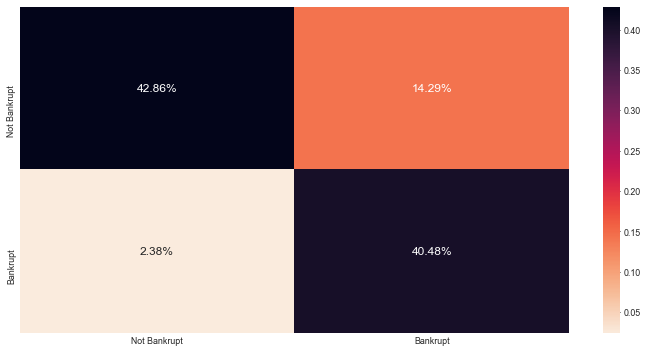

None

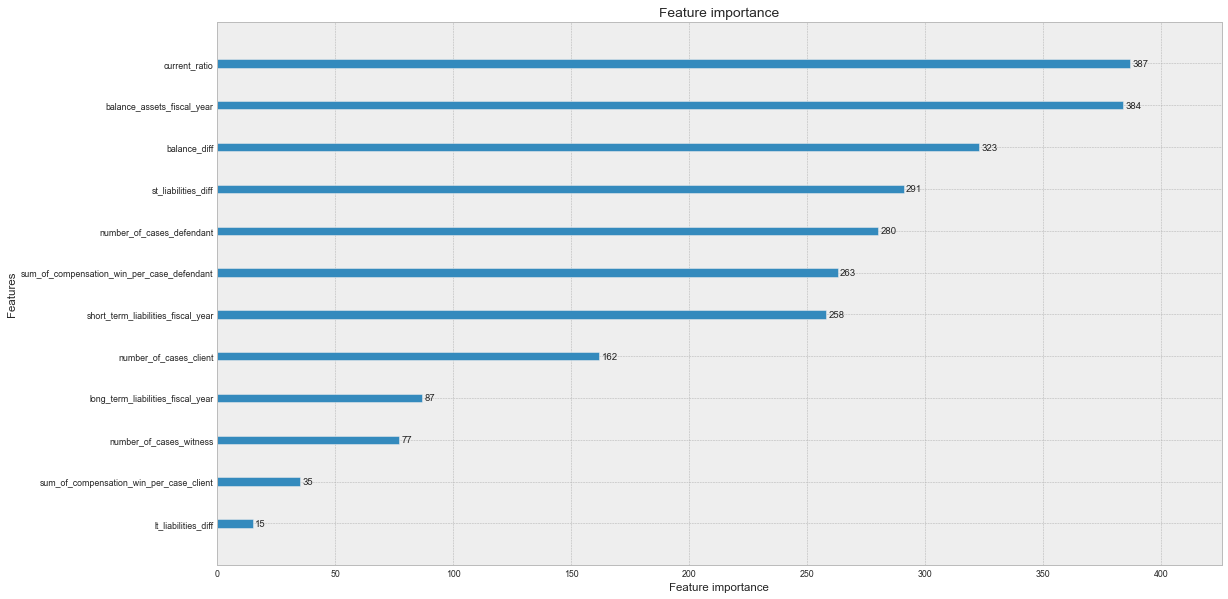

In [112]:
model_test(lgbm_params, 'Test LGBM Optuna', cm=True, fi=True)

LGBMClassifier переучился на 
* Сurrent ratio
* Баланс
* Прирост баланса и краткосрочных долгов.

Ошибки снизились, метрики выросли.

In [113]:
model_result()

,MODEL_NAME,ROCAUC,F1
5,Test LGBM Optuna,0.8611,0.8293
4,Test CB Raw,0.8611,0.8000
3,Test LGBM Raw,0.8079,0.7805
1,LGBM CV,0.8023,0.6827
0,CatBoost CV,0.7882,0.6758
2,XGBoost CV,0.7840,0.6570


### CB Optuna

Повторим тюнинг для CatBoost.

In [114]:
%%time
def objective(trial,data=x_train,target=y_train):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=seed, stratify=target)
    
    params = {
        'random_state': seed,
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }

    model = CatBoostClassifier(
        eval_metric="AUC",
        task_type="GPU",
        l2_leaf_reg=50,
        **params
    )        
    model.fit(train_x,
              train_y,
              eval_set=(test_x,test_y),
              early_stopping_rounds=100,
              verbose=False)
   
    preds = model.predict_proba(test_x)[:,1]
    auc_score = roc_auc_score(test_y, preds)
    
    return auc_score


Wall time: 0 ns


In [115]:
%%time
study = optuna.create_study(direction = "maximize", sampler = TPESampler(seed=int(seed)))
study.optimize(objective, n_trials = 50)

[I 2021-08-15 23:40:53,366] A new study created in memory with name: no-name-b1048fdf-2afb-4e78-8bce-41585fe10d0e
[I 2021-08-15 23:40:54,413] Trial 0 finished with value: 0.8979591836734694 and parameters: {'iterations': 174, 'depth': 5, 'learning_rate': 0.023843278019435605, 'random_strength': 40, 'bagging_temperature': 0.3230430416459653, 'od_type': 'IncToDec'}. Best is trial 0 with value: 0.8979591836734694.
[I 2021-08-15 23:40:56,233] Trial 1 finished with value: 0.9336734693877551 and parameters: {'iterations': 243, 'depth': 9, 'learning_rate': 0.028702610534905356, 'random_strength': 35, 'bagging_temperature': 0.25530497042690464, 'od_type': 'Iter'}. Best is trial 1 with value: 0.9336734693877551.
[I 2021-08-15 23:40:57,389] Trial 2 finished with value: 0.9183673469387755 and parameters: {'iterations': 278, 'depth': 7, 'learning_rate': 0.02905437629361598, 'random_strength': 89, 'bagging_temperature': 4.99220330301688, 'od_type': 'Iter'}. Best is trial 1 with value: 0.93367346938

[I 2021-08-15 23:41:32,375] Trial 26 finished with value: 0.8673469387755103 and parameters: {'iterations': 199, 'depth': 10, 'learning_rate': 0.015328142327981574, 'random_strength': 60, 'bagging_temperature': 23.05100014304744, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.9591836734693878.
[I 2021-08-15 23:41:33,422] Trial 27 finished with value: 0.9030612244897959 and parameters: {'iterations': 140, 'depth': 8, 'learning_rate': 0.05444389747651899, 'random_strength': 72, 'bagging_temperature': 2.51206505345127, 'od_type': 'Iter'}. Best is trial 3 with value: 0.9591836734693878.
[I 2021-08-15 23:41:34,529] Trial 28 finished with value: 0.9438775510204082 and parameters: {'iterations': 97, 'depth': 10, 'learning_rate': 0.013707260124929803, 'random_strength': 83, 'bagging_temperature': 0.05852965119452921, 'od_type': 'IncToDec'}. Best is trial 3 with value: 0.9591836734693878.
[I 2021-08-15 23:41:35,204] Trial 29 finished with value: 0.8979591836734694 and parameters: {'itera

Wall time: 1min 4s


In [116]:
print('CatBoost Hyperparameter:', study.best_trial.params)

CatBoost Hyperparameter: {'iterations': 181, 'depth': 10, 'learning_rate': 0.06982119935624141, 'random_strength': 67, 'bagging_temperature': 0.016182095669776804, 'od_type': 'IncToDec'}


In [117]:
cb_params = study.best_params   
cb_params['random_state'] = seed

Threshold=0.479, F1-Score=0.80000, ROC-AUC score=0.84028,

Test CB Optuna Confusion matrix


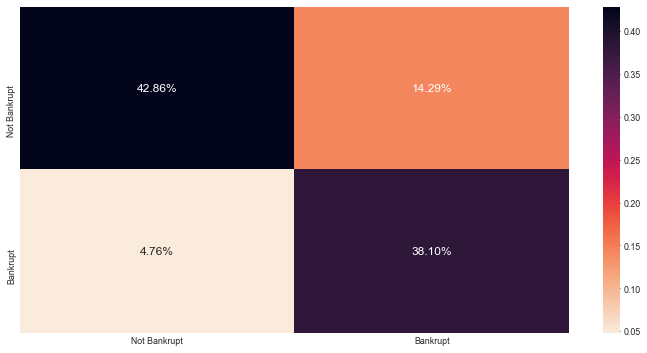

None

,feature_importance,feature_names
2,26.4313,number_of_cases_defendant
7,11.5867,balance_assets_fiscal_year
11,11.4749,current_ratio
4,9.0237,sum_of_compensation_win_per_case_defendant
10,8.8709,balance_diff
9,7.1821,st_liabilities_diff
6,6.8103,short_term_liabilities_fiscal_year
0,5.1895,number_of_cases_client
3,4.8631,number_of_cases_witness
5,4.1201,long_term_liabilities_fiscal_year


In [118]:
model_test(cb_params, 'Test CB Optuna', cb=True, cm=True, fi=True)

А CatBoost наоборот переобучился на судебные дела. 

После подбора гиперпарметров F1-score не изменился, а ROC-AUC даже снизлся на два пункта.

In [119]:
model_result()

,MODEL_NAME,ROCAUC,F1
5,Test LGBM Optuna,0.8611,0.8293
4,Test CB Raw,0.8611,0.8000
6,Test CB Optuna,0.8403,0.8000
3,Test LGBM Raw,0.8079,0.7805
1,LGBM CV,0.8023,0.6827
0,CatBoost CV,0.7882,0.6758
2,XGBoost CV,0.7840,0.6570


**Вывод:**

Используя библиоткеу Optuna подобрали гиперпараметры для каждой из моделей. 
* Для LGBM подбор привел к росту метрик на холдауте
* Для CatBoost затюнены гиперпарметры только снизили ROC-AUC.

## Определение итоговой модели

### CV

Сохраним лучшие моедли в переменные.

Провдем повторную кросс-валидацию на трейне для новых затюненых моделей. 

In [120]:
final_model_lgbm = LGBMClassifier(**lgbm_params)
final_model_cb = CatBoostClassifier(**cb_params)

In [121]:
def tuned_model_cv(name, model):
      
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=10,  random_state=seed)

    scores_rocauc = cross_val_score(model, x_train, y_train,
                             cv=cv, scoring='roc_auc')
    scores_f1 = cross_val_score(model, x_train, y_train,
                             cv=cv, scoring='f1')
    
    MODEL_NAME.append(name)
    ROCAUC.append(scores_rocauc.mean())
    F1.append(scores_f1.mean())

In [122]:
tuned_models = [final_model_lgbm, final_model_cb]
ml_model_names = ['Tuned LGBM CV', 'Tuned CatBoost CV']

In [123]:
for name, model in tqdm(zip(ml_model_names, ml_models)):
    tuned_model_cv(name, model)

In [124]:
final_result = model_result().head(8)

In [125]:
final_result.sort_index()

,MODEL_NAME,ROCAUC,F1
0,CatBoost CV,0.7882,0.6758
1,LGBM CV,0.8023,0.6827
3,Test LGBM Raw,0.8079,0.7805
4,Test CB Raw,0.8611,0.8000
5,Test LGBM Optuna,0.8611,0.8293
6,Test CB Optuna,0.8403,0.8000
7,Tuned LGBM CV,0.8293,0.7415
8,Tuned CatBoost CV,0.7996,0.7166


Настало время определиться, какую модель будем считать финальной.
1. Скоры обеих моделей на повторной кросс-валидации подросли. Это жолжно означать что затюненые моедли лучше.
1. LGBMClassifier был лучше CatBoostClassifier на всех основных этапах:
     * на начальной кросс-валидации
     * на холдаут выборке
     * на повторной кросс-валидации
     
Итоговая модель - LGBM затюненый с помощью Optuna.

In [126]:
FINAL_MODEL = final_model_lgbm

### Seed-check

Прогоняем полученную моедь через расчет метрик на 30 разных сидах.

In [127]:
def check_seed_final(model, df=df, test_size_=0.25, range_=30, name_='final_model', cv_=True,):
    
    seed_NAME = []
    seed_SEED = []
    seed_F1_baseline = []
    seed_ROCAUC_model = []
    seed_F1_model= []
    seed_THRSH_model = []
    thresholds = np.arange(0, 1, 0.001)
    
    for seed_ in tqdm(range(range_)):

        x = df.drop(['is_bankrupt'], axis=1)
        y = df.is_bankrupt

        x_train, x_test, y_train, y_test = train_test_split(x,
                                                            y,
                                                            test_size=test_size_,
                                                            stratify=y,
                                                            random_state=seed_)

        dummy_prediction_test = [0 if x < 0 else 1 for x in x_test.st_liabilities_diff]
        
        smote = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=seed)
        x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train) 
        scalar = StandardScaler()
        x_train = scalar.fit_transform(x_train_smote)
        x_test = scalar.transform(x_test)
        y_train = y_train_smote
        
        model.fit(x_train, y_train)

        pred_proba = model.predict_proba(x_test)[:,1]
        scores = [f1_score(y_test, to_labels(pred_proba, t)) for t in thresholds]
        ix = np.argmax(scores)

        thrsh = thresholds[ix]
        f1_cb_test = scores[ix]
        roc_auc_cb_test = roc_auc_score(y_test, pred_proba)
        f1_baseline_test = f1_score(y_test, dummy_prediction_test)

        seed_NAME.append(name_) 
        seed_SEED.append(seed_) 
        seed_F1_baseline.append(f1_baseline_test)
        seed_ROCAUC_model.append(roc_auc_cb_test)
        seed_F1_model.append(f1_cb_test)
        seed_THRSH_model.append(thrsh)
        
    results = pd.DataFrame({'NAME': seed_NAME,
                            'SEED': seed_SEED,    
                            'F1_baseline': seed_F1_baseline,
                            'F1_model': seed_F1_model,
                            'THRSH_model': seed_THRSH_model,
                            'ROCAUC_model': seed_ROCAUC_model})
    
    results['diff'] = results.F1_model - results.F1_baseline
    results.loc['mean'] = results.mean()
    results.sort_values('diff', ascending=False, inplace=True)
    
    return results

In [128]:
seed_final = check_seed_final(FINAL_MODEL)

Сравниваем средние значения для новой затюненой модели LGBM и предсказания ванильным CatBoost.

In [129]:
final_mean = seed_final.loc['mean']
baseline_mean = seed_baseline.loc['mean']
baseline_mean.index = final_mean.index
final_seed_compare = pd.concat([final_mean, baseline_mean], axis=1)
final_seed_compare.iloc[0] = ['Final', 'Baseline']
final_seed_compare = final_seed_compare.reset_index()
final_seed_compare.columns = final_seed_compare.iloc[0]
final_seed_compare = final_seed_compare.drop(final_seed_compare.index[0])
final_seed_compare = final_seed_compare.drop(final_seed_compare.index[0]).reset_index(drop=True)

In [130]:
final_seed_compare

,NAME,Final,Baseline
0,F1_baseline,0.5981,0.5981
1,F1_model,0.7499,0.7547
2,THRSH_model,0.3686,0.4445
3,ROCAUC_model,0.7958,0.8054
4,diff,0.1518,0.1566


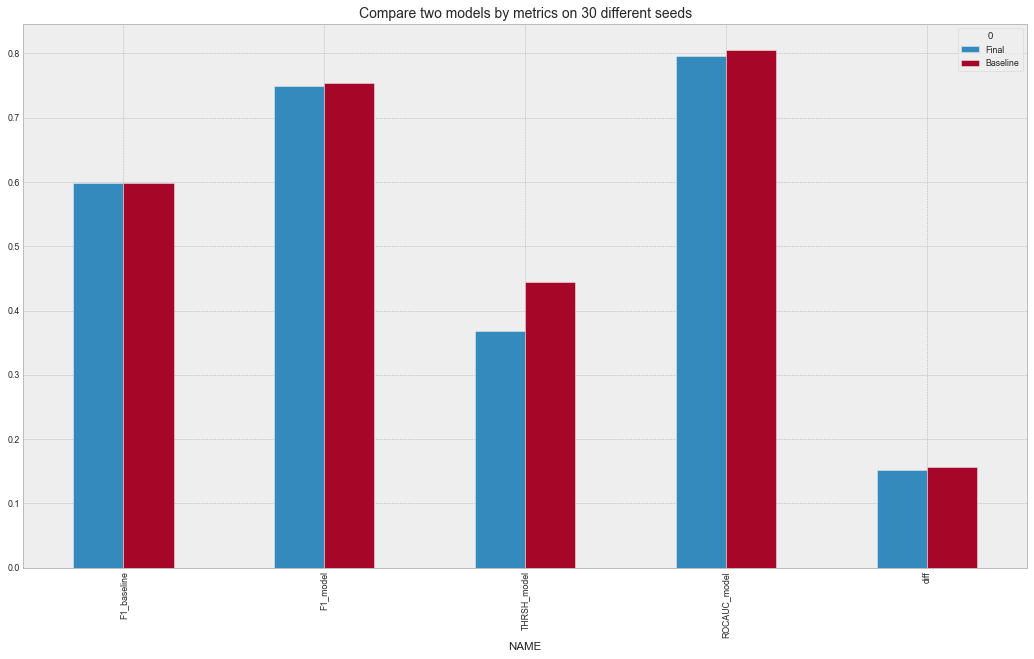

In [131]:
final_seed_compare.plot(x="NAME", y=["Final", "Baseline"], kind="bar");
plt.title('Compare two models by metrics on 30 different seeds', fontsize=14)
plt.show()

Увы и ах. Метрики на предыдущих этапах говорили нам о том, что новая моедль должна справиться лучше с различными разбияениями на трейн и холдаут. В реальности значения целевых метрик даже немнго снизились. 
Предпологаю это произошло не потому, что новая моедль хуже базовой, просто статистическая погрешность.

### Bootstrap

Чтобы хоть как-то оценить доверительный интервал целевых метрик на новой модели повторим рассчеты для 1000 разных знаений seed. 


In [132]:
seed_final_boots = check_seed_final(FINAL_MODEL, range_=1000)

Bootstrap method


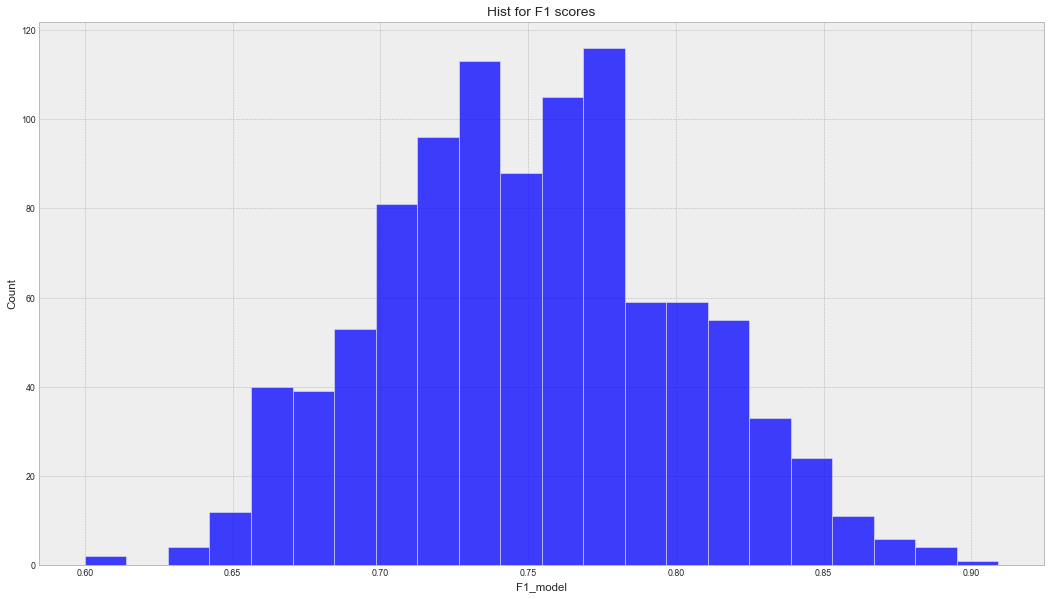

Average F1 score: 0.75
95% confidence interval for F1 score: [0.67 : 0.85]
-------------------------------------------------------------------------------------------------------------------------------


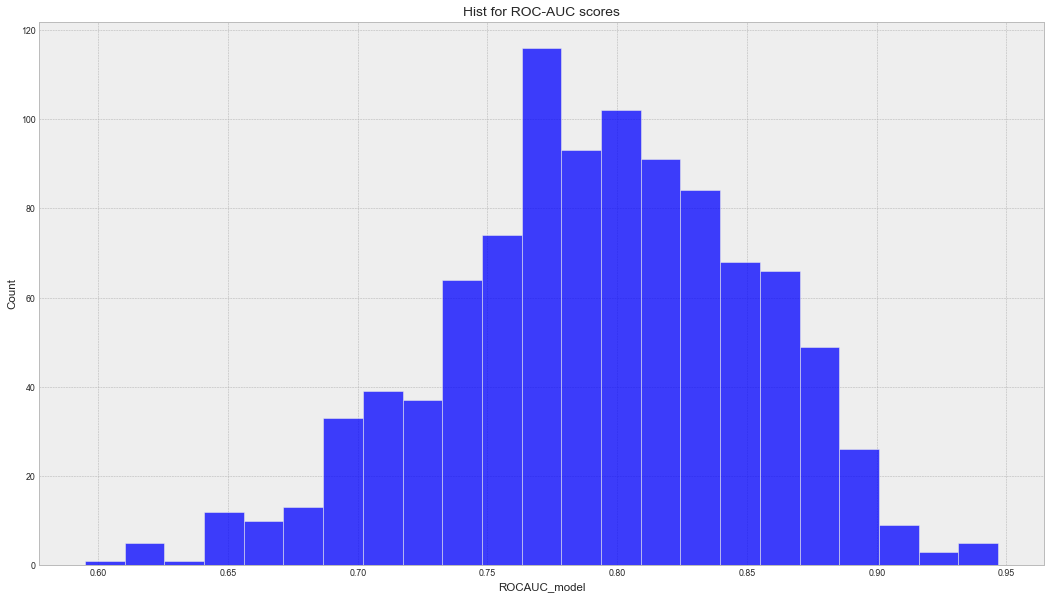

Average ROC-AUC score: 0.79
95% confidence interval for ROC-AUC score: [0.66 : 0.90]


In [133]:
print(f'Bootstrap method')

b_f1 = seed_final_boots.F1_model
b_rocauc = seed_final_boots.ROCAUC_model

sns.histplot(b_f1).set_title(f'Hist for F1 scores')
plt.show()

mean = b_f1.mean()
upper = b_f1.quantile(0.975)
lower = b_f1.quantile(0.025)

print(f'Average F1 score: {mean:.2f}')
print(f'95% confidence interval for F1 score: [{lower:.2f} : {upper:.2f}]')

print('-'*127)

sns.histplot(b_rocauc).set_title(f'Hist for ROC-AUC scores')
plt.show()

mean = b_rocauc.mean()
upper = b_rocauc.quantile(0.975)
lower = b_rocauc.quantile(0.025)

print(f'Average ROC-AUC score: {mean:.2f}')
print(f'95% confidence interval for ROC-AUC score: [{lower:.2f} : {upper:.2f}]')

**Вывод:**
* Как и отмечал в начале проекта датасет для посторения применимой моедли очень мал. Качество, которое обеспечивает моедль сильно зависист от того какой именно типа наблюдений мы будет классифицировать.
* Есть и плюсы - удалось оценить качество модели, и подветрдить, что в 97,5% случаев метрика F1 score не будет ниже 0,67. Это на 0,07 больше чем среднее значение этой метрики у бэйзлайн моедли. Какой-то прирост к качеству все же получен.

## Итоговый вывод

Перед нами стояла задача построить предиктивную модель, которая на основании открытых данных о судах и бухгалтерской отчетности позволит спрогнозировать вероятность банкротства компании. 

В качестве целевых метрики были выбраны **F1** и **ROC-AUC**.

На основе файлов  df_accounts и df_bankruptcies_sample был сформирован датафрейм в котором размечены компании-банкроты. 

Датафрейм включал в себя ИНН компании и некоторые финансовые данные. Общее кол-во компаний - 166 шт.

Для каждой компании были рассчитаны значения признаков на основе json-файлоы судебных дел. 

Итоговый датафрейм содержал в себе 166 наблюдений, и 47 признаков. Один из них целевой - является компания банкротом, или нет.


### EDA

Распредление целевой переменной выглядело так

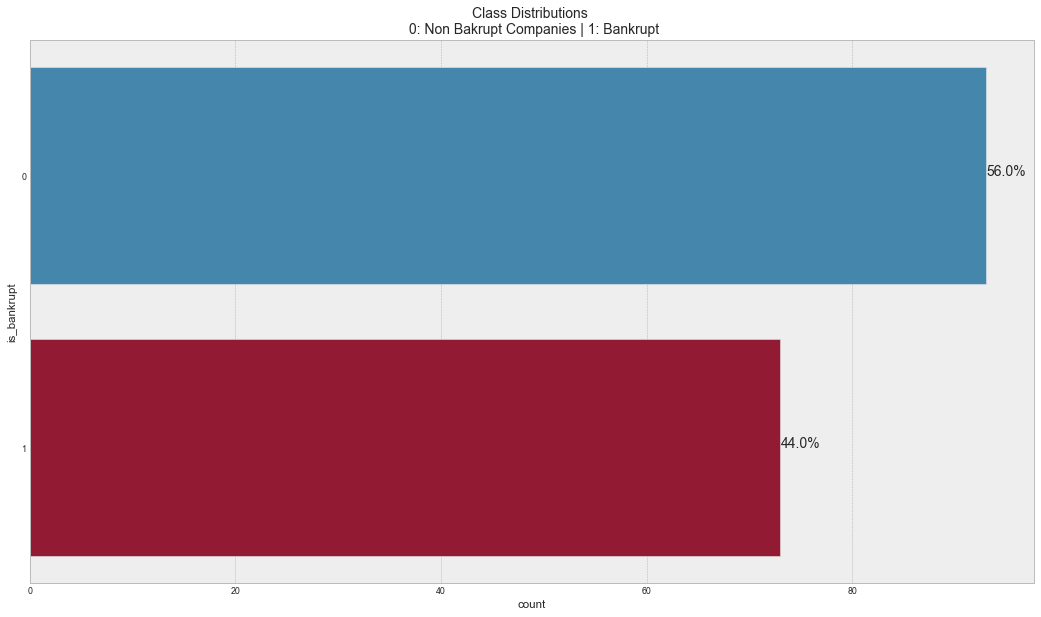

In [69]:
ax = sns.countplot(y="is_bankrupt", data=df)
plt.title('Class Distributions \n 0: Non Bakrupt Companies | 1: Bankrupt', fontsize=14)

total = len(df['is_bankrupt'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=14)

plt.show()

В ходе EDA были проанализированы получившиеся признаки. Часть из них, которые в большинстве своем состояли из нулевых значений были отброшены сразу. Другая часть отпала в процессе валидации. Итого из 46 признаков, две из которых (ИНН компании, Имя компании) не являлись релевантными для построения моделй было оставлено 12. 

Наиболее успешно показавшие себя в построении моделей: 

* number_of_cases_defendant - кол-во судебных дел компании в качестве ответчика
* balance_assets_fiscal_year - активы на момент получения данных
* current_ratio - отношение всех задолженностей к активам
* balance_diff - как изменился баланс активов за последний год
* st_liabilities_diff - как изменились краткосрочные задолженности за последний год.

Часть из них, а именно balance_diff и st_liabilities_diff в ходе EDA были отмечены как хорошо описывающие разницу между компаниями-банкротами и остальными.

В частности два графика снизу показывают что банкротом можно отделить по снижающимся активам и повышению краткосрочных задолженностей, что выглядит весьма логично.


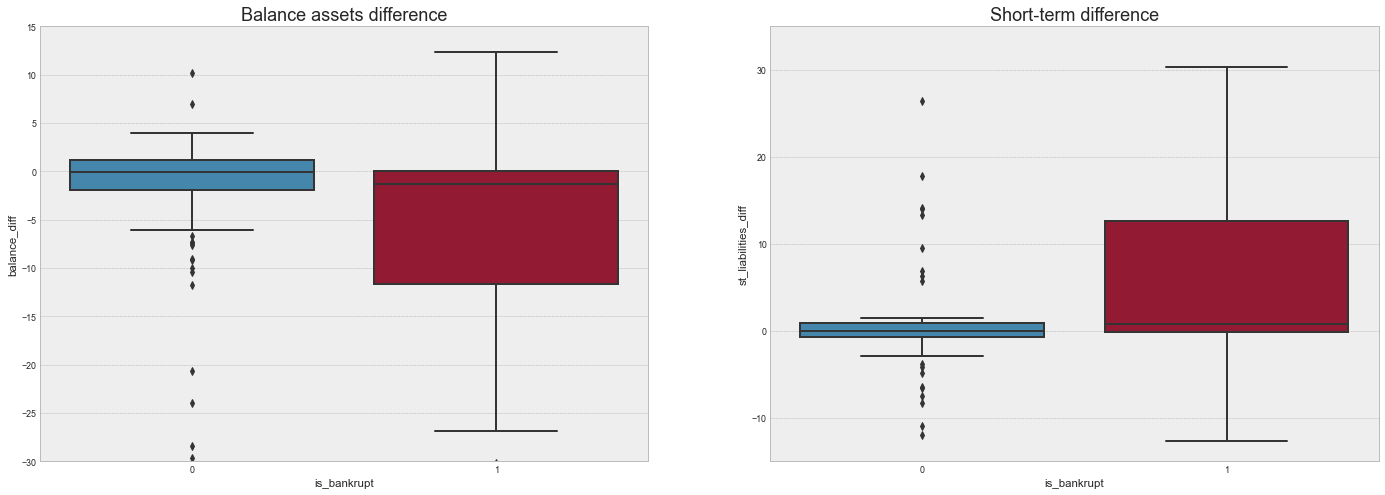

In [136]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x="is_bankrupt", y='balance_diff', data=df,ax=ax1) 
ax1.set_title("Balance assets difference", fontsize=18)
ax1.set_ylim(-30,15)

sns.boxplot(x="is_bankrupt", y='st_liabilities_diff', data=df,ax=ax2) 
ax2.set_title("Short-term difference", fontsize=18)
ax2.set_ylim(-15,35)
                 
plt.show()

### Постановка ML задачи

Иначальная проблема с этими данными - очень скудное кол-во наблюдений. 

Было очевидно, что стандартная схема с отложенной выборкой не сработает, т.к. поведение метрик будет зависеть от того, какие именно наблюдения попадуут в холдаут. Причина - разные распредления велечин в трейне и холдауте.

Для сравнения использовали бэйлайн модель которая сравнивала st_liabilities_diff с нулем, и на основе реузльтата предсказывал таргет. (см. график выше)

Проведя проверку для 30 разных параметров случайного состояния было выявлено, что разбег значений метрики F1 составляет почти 0,2, а разница с бэйзлайн предскзанием  составляла от 0 до +0,3.

Было решено следующее:

Проводим стандартные процедуры: отделяет холдаут, препроцессинг фичей, выбираем моедли с помощью кросс валидации, тюнингуем, считаем скор на холдауте.

После этого идем в обратном порядке - запускаем кросс-валидацию на трейне с новой моделью, смотрим как изменятся метрики при 30 разных seed. 

Все для того, чтобы понимать - не переобучились ли мы под холдаут и выбрать модель которая хороша на каждом этапе.

### Результаты

На кросс валидации по всем данным трейна лучше всего себя показала затюненая версия LGBMClassifier. Прирост в метриках тоже получен.

In [144]:
final_result[~final_result.MODEL_NAME.str.startswith('Test')]

,MODEL_NAME,ROCAUC,F1
7,Tuned LGBM CV,0.8293,0.7415
1,LGBM CV,0.8023,0.6827
8,Tuned CatBoost CV,0.7996,0.7166
0,CatBoost CV,0.7882,0.6758


На тестовых данных тоже лучше всего себя показала затюненая версия LGBMClassifier. И здесь по всем метрикам есть прирост.

In [142]:
final_result[final_result.MODEL_NAME.str.startswith('Test')]

,MODEL_NAME,ROCAUC,F1
5,Test LGBM Optuna,0.8611,0.8293
4,Test CB Raw,0.8611,0.8000
6,Test CB Optuna,0.8403,0.8000
3,Test LGBM Raw,0.8079,0.7805


Эта модель и была выбраная как итоговая.

Осталось только сравнить ее метрики с бэйзлайн предсказаниями на разных seed. 

In [146]:
final_seed_compare

,NAME,Final,Baseline
0,F1_baseline,0.5981,0.5981
1,F1_model,0.7499,0.7547
2,THRSH_model,0.3686,0.4445
3,ROCAUC_model,0.7958,0.8054
4,diff,0.1518,0.1566


Но увы, здесь статзначимых отличий найти невозможно - метрики остались на том же уровне.

Из положительных моментов - предсказываем лучше дамми бэйзлайна на 15 пунктов F1 метрики, в среднем.

Как и ожидалось, для такого маленького датасета все зависит от того распредления, которое попадет в холдаут.

Но основая задача проекта была выполнена - исходя из имеющихся данных мы с опредленной точностью можем предсказывать потенциальных банкротов.

Оценим 95% доверительный инетрвал целевых метрик предсказания финальной модели.

Он составит:
* для **F1 score: [0.67 : 0.85]**
* для **ROC-AUC score: [0.66 : 0.90]**

Bootstrap method


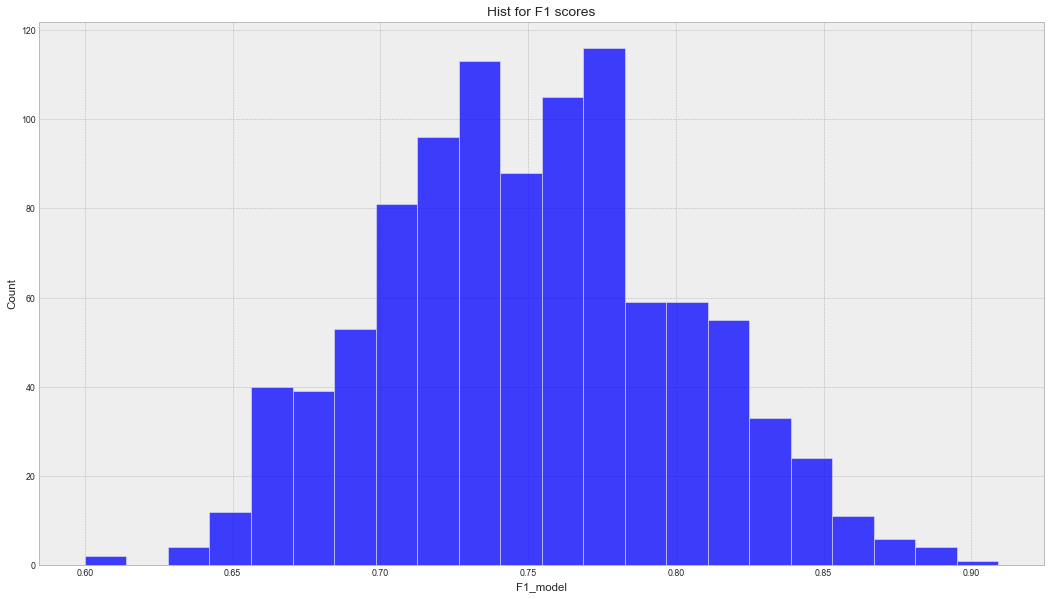

Average F1 score: 0.75
95% confidence interval for F1 score: [0.67 : 0.85]
-------------------------------------------------------------------------------------------------------------------------------


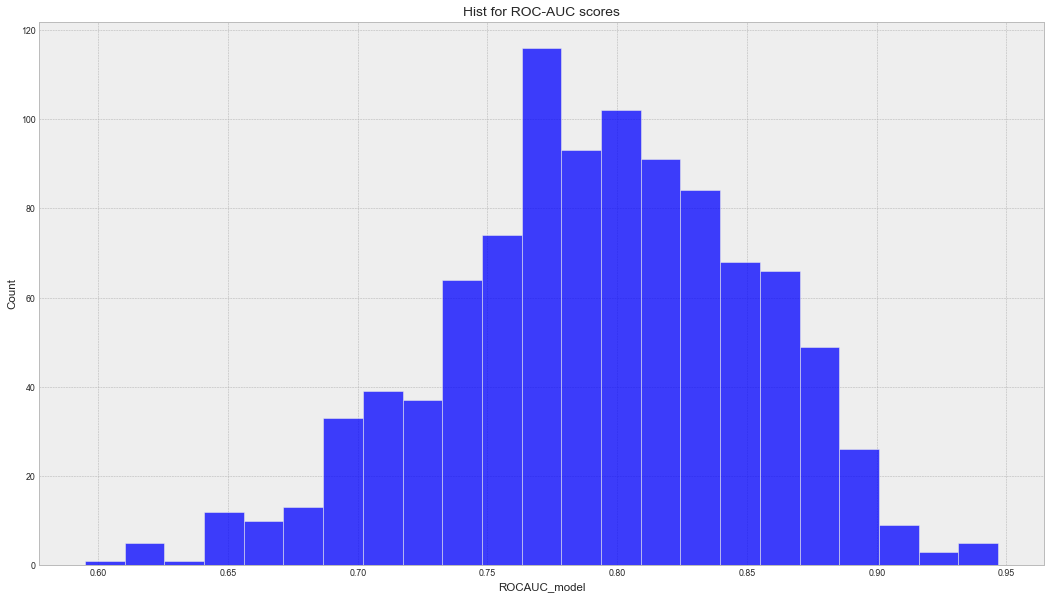

Average ROC-AUC score: 0.79
95% confidence interval for ROC-AUC score: [0.66 : 0.90]


In [147]:
print(f'Bootstrap method')

b_f1 = seed_final_boots.F1_model
b_rocauc = seed_final_boots.ROCAUC_model

sns.histplot(b_f1).set_title(f'Hist for F1 scores')
plt.show()

mean = b_f1.mean()
upper = b_f1.quantile(0.975)
lower = b_f1.quantile(0.025)

print(f'Average F1 score: {mean:.2f}')
print(f'95% confidence interval for F1 score: [{lower:.2f} : {upper:.2f}]')

print('-'*127)

sns.histplot(b_rocauc).set_title(f'Hist for ROC-AUC scores')
plt.show()

mean = b_rocauc.mean()
upper = b_rocauc.quantile(0.975)
lower = b_rocauc.quantile(0.025)

print(f'Average ROC-AUC score: {mean:.2f}')
print(f'95% confidence interval for ROC-AUC score: [{lower:.2f} : {upper:.2f}]')

## Save Model

In [149]:
FINAL_MODEL = final_model_lgbm

In [150]:
FINAL_MODEL.fit(x,y)

LGBMClassifier(cat_smooth=42, colsample_bytree=0.8, learning_rate=0.02,
               max_depth=20, min_child_samples=4, n_estimators=155,
               num_leaves=24, random_state=50, reg_alpha=0.188040590353945,
               reg_lambda=0.001055529904809917)

In [153]:
import joblib
# save model
joblib.dump(FINAL_MODEL, 'lgb_final.pkl')

['lgb_final.pkl']

In [154]:
# save features
joblib.dump(feature_columns, 'selected_features.pkl')

['selected_features.pkl']